# Legislative Impact Analysis of Climate Change Twitter Discourse

This notebook analyzes the relationship between Twitter discussions about climate change and legislative actions. We focus on two specific topics:
1. Seriousness of Gas Emissions
2. Ideological Positions on Global Warming

We'll examine how tweet sentiment, aggressiveness, and volume correlate with legislative responses.

## 1. Import Required Libraries and Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Configure matplotlib for better visualization
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['axes.grid'] = True
plt.rcParams['font.size'] = 12

# Load the datasets
print("Loading datasets...")
df_tweets = pd.read_csv('The Climate Change Twitter Dataset.csv')
df_bills = pd.read_excel('Bill_new.xlsx')

print("\nDataset Information:")
print(f"Tweets dataset shape: {df_tweets.shape}")
print(f"Bills dataset shape: {df_bills.shape}")

# Display unique topics in tweets
print("\nUnique topics in tweets:")
print(df_tweets['topic'].unique())

Loading datasets...

Dataset Information:
Tweets dataset shape: (15789411, 10)
Bills dataset shape: (2500, 1059)

Unique topics in tweets:
['Weather Extremes' 'Importance of Human Intervantion'
 'Seriousness of Gas Emissions' 'Ideological Positions on Global Warming'
 'Impact of Resource Overconsumption' 'Global stance' 'Politics'
 'Significance of Pollution Awareness Events'
 'Donald Trump versus Science' 'Undefined / One Word Hashtags']


## 2. Data Preparation Functions

This section contains functions to prepare and organize our data by topic. We'll:
1. Convert date strings to datetime objects
2. Filter tweets and bills by topic
3. Create monthly aggregations of tweet metrics and legislative activity

In [2]:
def prepare_topic_based_data():
    # Convert dates to datetime
    df_tweets['created_at'] = pd.to_datetime(df_tweets['created_at'])
    df_bills['Date of Introduction'] = pd.to_datetime(df_bills['Date of Introduction'])
    
    # Fill NaN values in bill titles
    df_bills['Title'] = df_bills['Title'].fillna('')
    
    # Define topics of interest and their keywords
    topics_of_interest = [
        'Seriousness of Gas Emissions',
        'Ideological Positions on Global Warming'
    ]
    
    topic_keywords = {
        'Seriousness of Gas Emissions': ['emission', 'carbon', 'greenhouse', 'methane', 'co2'],
        'Ideological Positions on Global Warming': ['climate', 'global warming', 'paris', 'climate change']
    }
    
    topic_analysis = {}
    
    for topic in topics_of_interest:
        print(f"\nProcessing topic: {topic}")
        
        # Filter tweets for this topic
        topic_tweets = df_tweets[df_tweets['topic'] == topic]
        print(f"Number of tweets: {len(topic_tweets)}")
        
        # Create monthly aggregations for tweets
        monthly_tweets = topic_tweets.groupby([topic_tweets['created_at'].dt.to_period('M')]).agg({
            'id': 'count',
            'aggressiveness': lambda x: (x == 'aggressive').mean(),
            'sentiment': 'mean'
        }).reset_index()
        monthly_tweets['created_at'] = monthly_tweets['created_at'].astype(str).apply(lambda x: pd.to_datetime(x + '-01'))
        
        # Filter bills related to this topic
        keywords = topic_keywords[topic]
        topic_bills = df_bills[
            df_bills['Title'].str.lower().apply(lambda x: any(keyword in str(x).lower() for keyword in keywords))
        ]
        print(f"Number of related bills: {len(topic_bills)}")
        
        # Create monthly aggregations for bills
        if not topic_bills.empty:
            monthly_bills = topic_bills.groupby([topic_bills['Date of Introduction'].dt.to_period('M')]).agg({
                'Legislation Number': 'count'
            }).reset_index()
            monthly_bills['Date of Introduction'] = monthly_bills['Date of Introduction'].astype(str).apply(lambda x: pd.to_datetime(x + '-01'))
        else:
            monthly_bills = pd.DataFrame(columns=['Date of Introduction', 'Legislation Number'])
        
        topic_analysis[topic] = {
            'tweets': monthly_tweets,
            'bills': monthly_bills,
            'raw_bills': topic_bills
        }
    
    return topic_analysis

# Prepare the data
topic_analysis = prepare_topic_based_data()


Processing topic: Seriousness of Gas Emissions
Number of tweets: 903478
Number of related bills: 338

Processing topic: Ideological Positions on Global Warming


/var/folders/wp/7gj1l4js36x19385y937b37c0000gn/T/ipykernel_91981/660640928.py:30: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  monthly_tweets = topic_tweets.groupby([topic_tweets['created_at'].dt.to_period('M')]).agg({


Number of tweets: 602695
Number of related bills: 471


/var/folders/wp/7gj1l4js36x19385y937b37c0000gn/T/ipykernel_91981/660640928.py:30: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  monthly_tweets = topic_tweets.groupby([topic_tweets['created_at'].dt.to_period('M')]).agg({


## 4. Visualize Results

Let's create visualizations to better understand the relationships between tweet characteristics and legislative activity.

In [3]:
def analyze_topic_legislative_response(topic_analysis):
    results = {}
    
    for topic, data in topic_analysis.items():
        print(f"\nAnalyzing topic: {topic}")
        
        if data['tweets'].empty:
            print("No tweets found for this topic")
            continue
            
        # Merge tweets and bills data
        merged = pd.merge(data['tweets'], data['bills'],
                         left_on='created_at', right_on='Date of Introduction', how='outer')
        merged = merged.sort_values('created_at')
        
        # Fill NaN values
        merged = merged.fillna({
            'aggressiveness': 0,
            'Legislation Number': 0,
            'sentiment': 0
        })
        
        # Calculate rolling averages
        merged['rolling_aggressiveness'] = merged['aggressiveness'].rolling(window=3).mean()
        merged['rolling_bills'] = merged['Legislation Number'].rolling(window=3).mean()
        merged['rolling_sentiment'] = merged['sentiment'].rolling(window=3).mean()
        
        # Calculate correlations
        correlations = {
            'Aggressiveness vs Bills': merged['aggressiveness'].corr(merged['Legislation Number']),
            'Sentiment vs Bills': merged['sentiment'].corr(merged['Legislation Number']),
            'Tweet Volume vs Bills': merged['id'].corr(merged['Legislation Number'])
        }
        
        print("\nCorrelations:")
        for metric, corr in correlations.items():
            print(f"{metric}: {corr:.3f}")
        
        # Calculate response timing
        high_aggressive_months = data['tweets'][
            data['tweets']['aggressiveness'] > data['tweets']['aggressiveness'].quantile(0.75)
        ]['created_at']
        
        response_times = []
        for event_date in high_aggressive_months:
            if not data['bills'].empty:
                future_bills = data['bills'][
                    (data['bills']['Date of Introduction'] > event_date) & 
                    (data['bills']['Date of Introduction'] <= event_date + pd.DateOffset(months=6))
                ]
                if not future_bills.empty:
                    min_response_time = (future_bills['Date of Introduction'].min() - event_date).days
                    response_times.append(min_response_time)
        
        timing_stats = {
            'avg_response_time': np.mean(response_times) if response_times else None,
            'median_response_time': np.median(response_times) if response_times else None,
            'min_response_time': min(response_times) if response_times else None,
            'max_response_time': max(response_times) if response_times else None
        }
        
        print("\nResponse Timing (days):")
        for metric, value in timing_stats.items():
            if value is not None:
                print(f"{metric}: {value:.1f}")
        
        # Analyze bill content
        bill_summary = {
            'total_bills': len(data['raw_bills']),
            'unique_sponsors': data['raw_bills']['Sponsor'].nunique() if not data['raw_bills'].empty else 0,
            'party_distribution': data['raw_bills']['Party of Sponsor'].value_counts().to_dict() if not data['raw_bills'].empty else {}
        }
        
        print("\nBill Summary:")
        print(f"Total Bills: {bill_summary['total_bills']}")
        print(f"Unique Sponsors: {bill_summary['unique_sponsors']}")
        print("Party Distribution:")
        for party, count in bill_summary['party_distribution'].items():
            print(f"  {party}: {count}")
        
        results[topic] = {
            'correlations': correlations,
            'timing': timing_stats,
            'bill_summary': bill_summary,
            'data': merged
        }
    
    return results

# Run the analysis
results = analyze_topic_legislative_response(topic_analysis)


Analyzing topic: Seriousness of Gas Emissions

Correlations:
Aggressiveness vs Bills: -0.249
Sentiment vs Bills: 0.112
Tweet Volume vs Bills: 0.135

Response Timing (days):
avg_response_time: 39.8
median_response_time: 31.0
min_response_time: 28.0
max_response_time: 122.0

Bill Summary:
Total Bills: 338
Unique Sponsors: 328
Party Distribution:
  Democratic: 181
  Republican: 152
  Independent: 5

Analyzing topic: Ideological Positions on Global Warming

Correlations:
Aggressiveness vs Bills: -0.361
Sentiment vs Bills: 0.046
Tweet Volume vs Bills: 0.022

Response Timing (days):
avg_response_time: 51.2
median_response_time: 31.0
min_response_time: 28.0
max_response_time: 181.0

Bill Summary:
Total Bills: 471
Unique Sponsors: 462
Party Distribution:
  Democratic: 345
  Republican: 120
  Independent: 6


In [4]:
def analyze_topic_legislative_response(topic_analysis):
    results = {}
    
    for topic, data in topic_analysis.items():
        print(f"\nAnalyzing topic: {topic}")
        
        if data['tweets'].empty:
            print("No tweets found for this topic")
            continue
            
        # Merge tweets and bills data
        merged = pd.merge(data['tweets'], data['bills'],
                         left_on='created_at', right_on='Date of Introduction', how='outer')
        merged = merged.sort_values('created_at')
        
        # Fill NaN values
        merged = merged.fillna({
            'aggressiveness': 0,
            'Legislation Number': 0,
            'sentiment': 0
        })
        
        # Calculate rolling averages
        merged['rolling_aggressiveness'] = merged['aggressiveness'].rolling(window=3).mean()
        merged['rolling_bills'] = merged['Legislation Number'].rolling(window=3).mean()
        merged['rolling_sentiment'] = merged['sentiment'].rolling(window=3).mean()
        
        # Calculate correlations
        correlations = {
            'Aggressiveness vs Bills': merged['aggressiveness'].corr(merged['Legislation Number']),
            'Sentiment vs Bills': merged['sentiment'].corr(merged['Legislation Number']),
            'Tweet Volume vs Bills': merged['id'].corr(merged['Legislation Number'])
        }
        
        print("\nCorrelations:")
        for metric, corr in correlations.items():
            print(f"{metric}: {corr:.3f}")
        
        # Calculate response timing
        high_aggressive_months = data['tweets'][
            data['tweets']['aggressiveness'] > data['tweets']['aggressiveness'].quantile(0.75)
        ]['created_at']
        
        response_times = []
        for event_date in high_aggressive_months:
            if not data['bills'].empty:
                future_bills = data['bills'][
                    (data['bills']['Date of Introduction'] > event_date) & 
                    (data['bills']['Date of Introduction'] <= event_date + pd.DateOffset(months=6))
                ]
                if not future_bills.empty:
                    min_response_time = (future_bills['Date of Introduction'].min() - event_date).days
                    response_times.append(min_response_time)
        
        timing_stats = {
            'avg_response_time': np.mean(response_times) if response_times else None,
            'median_response_time': np.median(response_times) if response_times else None,
            'min_response_time': min(response_times) if response_times else None,
            'max_response_time': max(response_times) if response_times else None
        }
        
        print("\nResponse Timing (days):")
        for metric, value in timing_stats.items():
            if value is not None:
                print(f"{metric}: {value:.1f}")
        
        # Analyze bill content
        bill_summary = {
            'total_bills': len(data['raw_bills']),
            'unique_sponsors': data['raw_bills']['Sponsor'].nunique() if not data['raw_bills'].empty else 0,
            'party_distribution': data['raw_bills']['Party of Sponsor'].value_counts().to_dict() if not data['raw_bills'].empty else {}
        }
        
        print("\nBill Summary:")
        print(f"Total Bills: {bill_summary['total_bills']}")
        print(f"Unique Sponsors: {bill_summary['unique_sponsors']}")
        print("Party Distribution:")
        for party, count in bill_summary['party_distribution'].items():
            print(f"  {party}: {count}")
        
        results[topic] = {
            'correlations': correlations,
            'timing': timing_stats,
            'bill_summary': bill_summary,
            'data': merged
        }
    
    return results

# Run the analysis
results = analyze_topic_legislative_response(topic_analysis)


Analyzing topic: Seriousness of Gas Emissions

Correlations:
Aggressiveness vs Bills: -0.249
Sentiment vs Bills: 0.112
Tweet Volume vs Bills: 0.135

Response Timing (days):
avg_response_time: 39.8
median_response_time: 31.0
min_response_time: 28.0
max_response_time: 122.0

Bill Summary:
Total Bills: 338
Unique Sponsors: 328
Party Distribution:
  Democratic: 181
  Republican: 152
  Independent: 5

Analyzing topic: Ideological Positions on Global Warming

Correlations:
Aggressiveness vs Bills: -0.361
Sentiment vs Bills: 0.046
Tweet Volume vs Bills: 0.022

Response Timing (days):
avg_response_time: 51.2
median_response_time: 31.0
min_response_time: 28.0
max_response_time: 181.0

Bill Summary:
Total Bills: 471
Unique Sponsors: 462
Party Distribution:
  Democratic: 345
  Republican: 120
  Independent: 6



Generating plots for: Seriousness of Gas Emissions


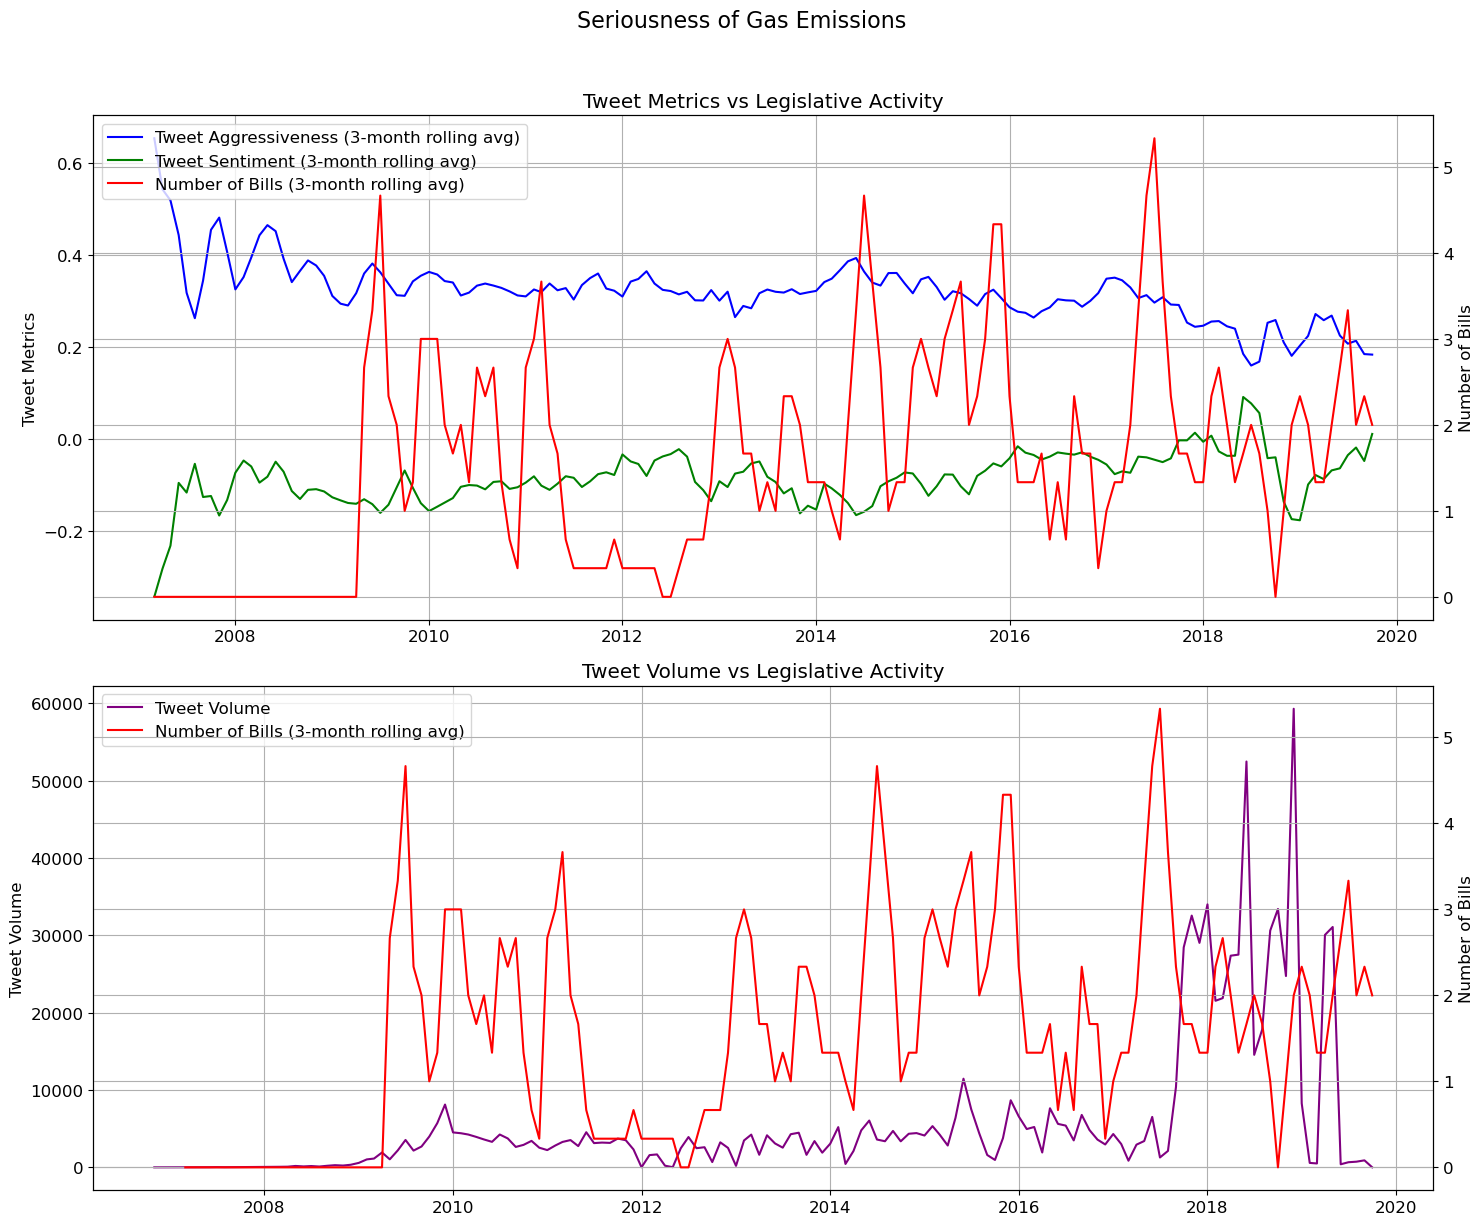


Generating plots for: Ideological Positions on Global Warming


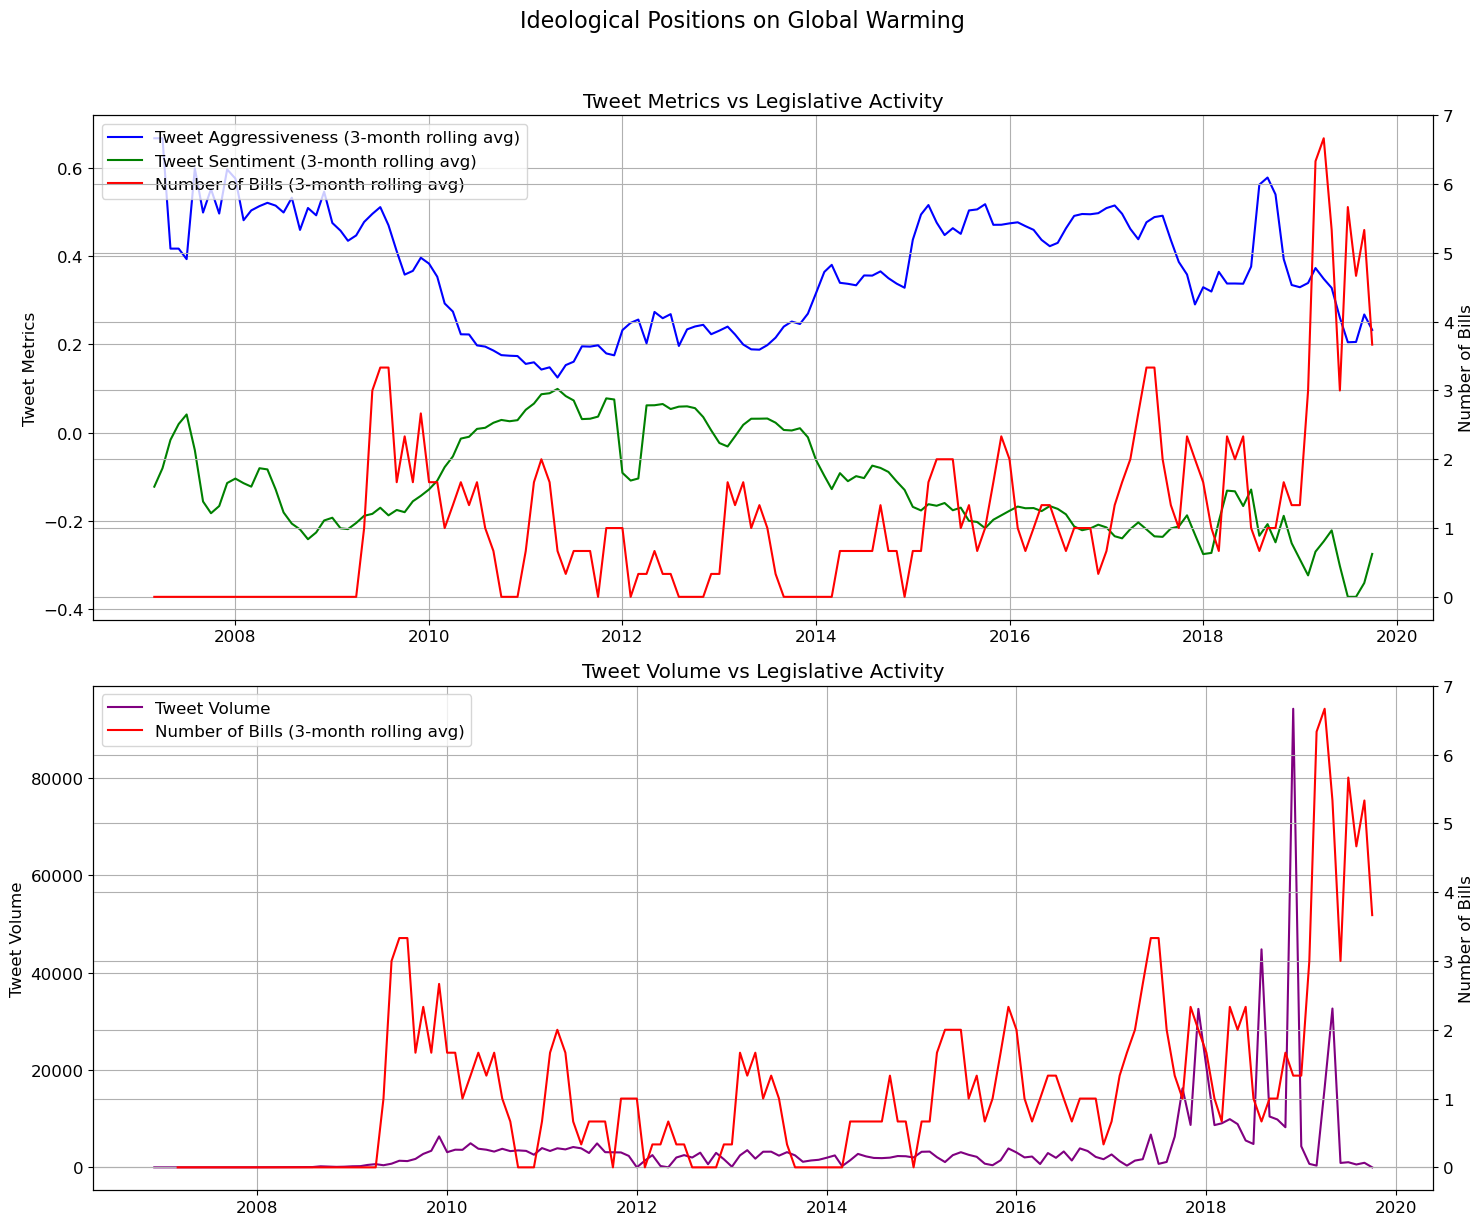

In [5]:
def plot_topic_relationships(results):
    for topic, data in results.items():
        print(f"\nGenerating plots for: {topic}")
        
        # Create a figure with 2 subplots
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
        fig.suptitle(topic, fontsize=16, y=1.02)
        
        merged = data['data']
        
        # Plot 1: Tweet metrics and legislative activity
        ax1.plot(merged['created_at'], merged['rolling_aggressiveness'], 
                label='Tweet Aggressiveness (3-month rolling avg)', color='blue')
        ax1.plot(merged['created_at'], merged['rolling_sentiment'],
                label='Tweet Sentiment (3-month rolling avg)', color='green')
        ax1_twin = ax1.twinx()
        ax1_twin.plot(merged['created_at'], merged['rolling_bills'], 
                     label='Number of Bills (3-month rolling avg)', color='red')
        
        ax1.set_title('Tweet Metrics vs Legislative Activity')
        ax1.set_ylabel('Tweet Metrics')
        ax1_twin.set_ylabel('Number of Bills')
        
        # Combine legends
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax1_twin.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
        
        # Plot 2: Tweet volume and legislative activity
        ax2.plot(merged['created_at'], merged['id'],
                label='Tweet Volume', color='purple')
        ax2_twin = ax2.twinx()
        ax2_twin.plot(merged['created_at'], merged['rolling_bills'],
                     label='Number of Bills (3-month rolling avg)', color='red')
        
        ax2.set_title('Tweet Volume vs Legislative Activity')
        ax2.set_ylabel('Tweet Volume')
        ax2_twin.set_ylabel('Number of Bills')
        
        # Combine legends
        lines1, labels1 = ax2.get_legend_handles_labels()
        lines2, labels2 = ax2_twin.get_legend_handles_labels()
        ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
        
        plt.tight_layout()
        plt.show()

# Generate the visualizations
plot_topic_relationships(results)

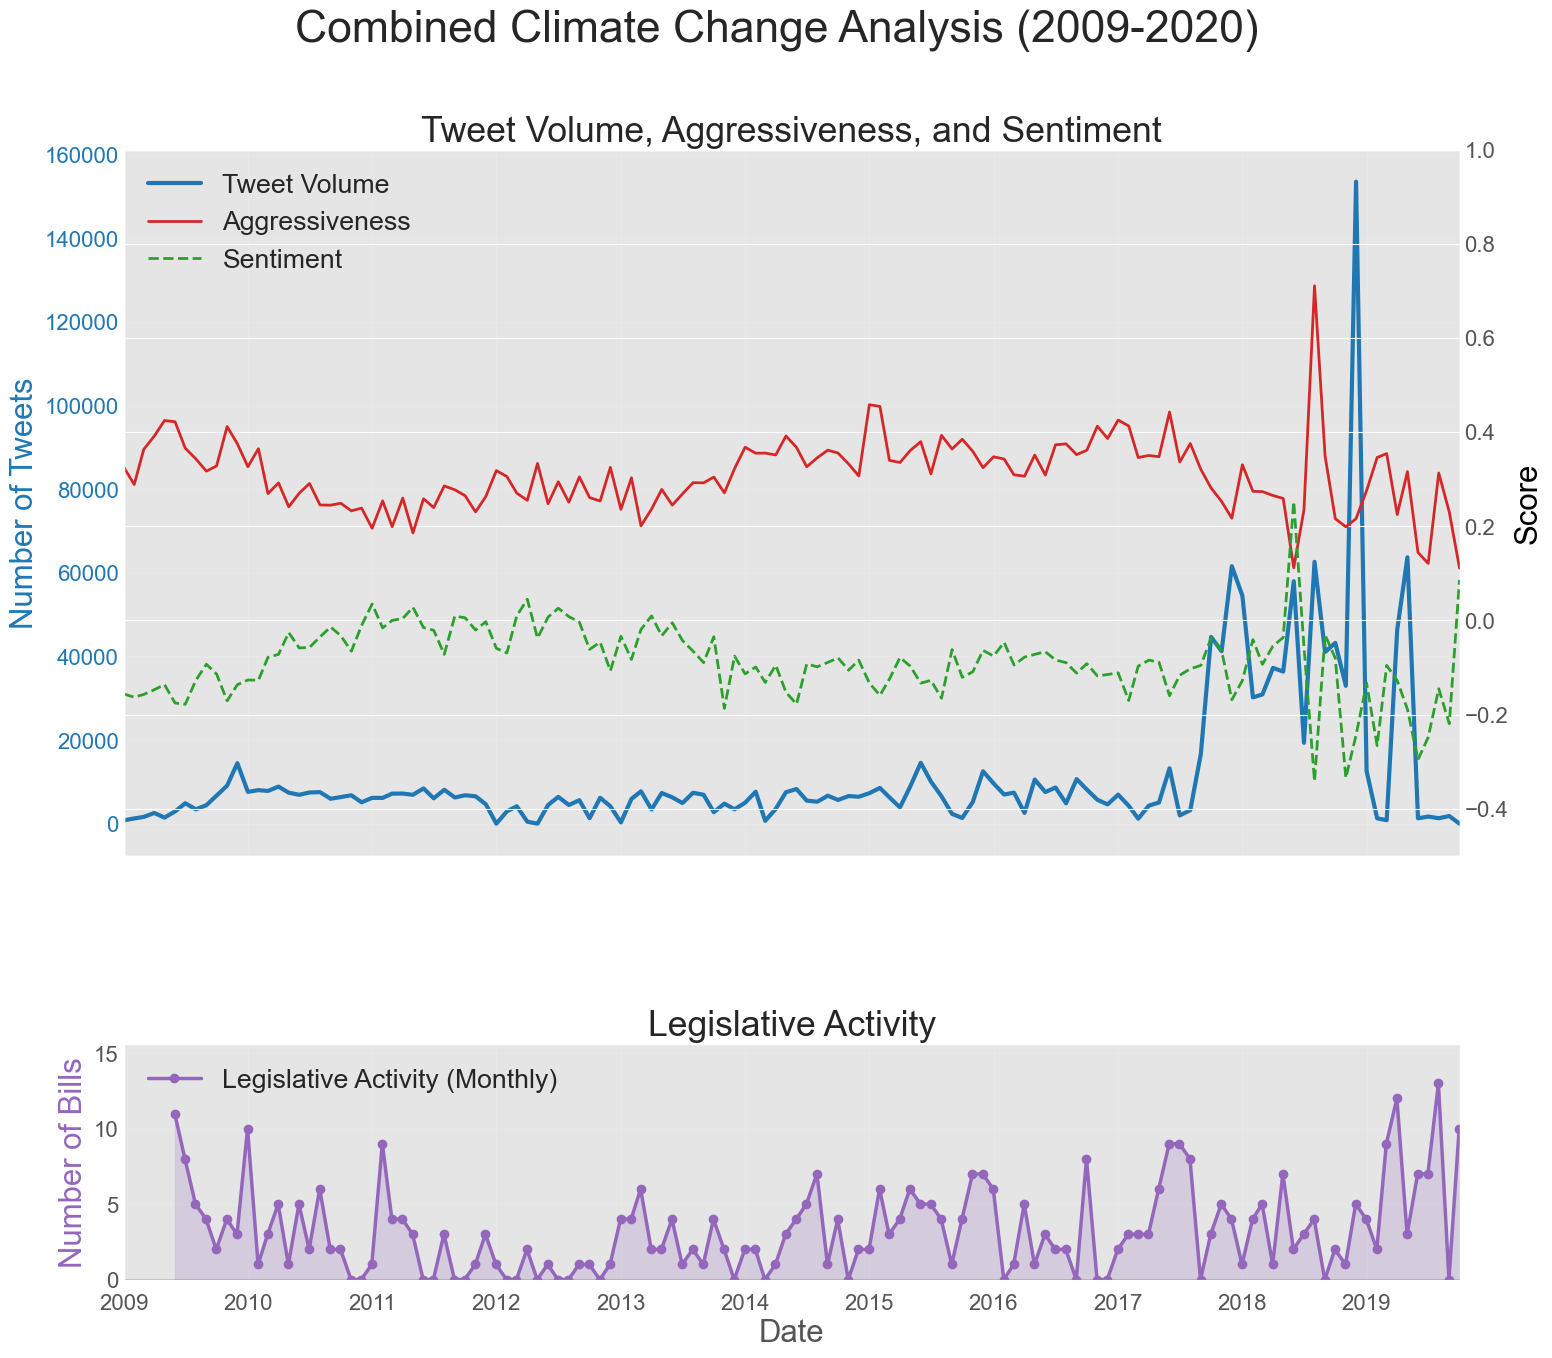

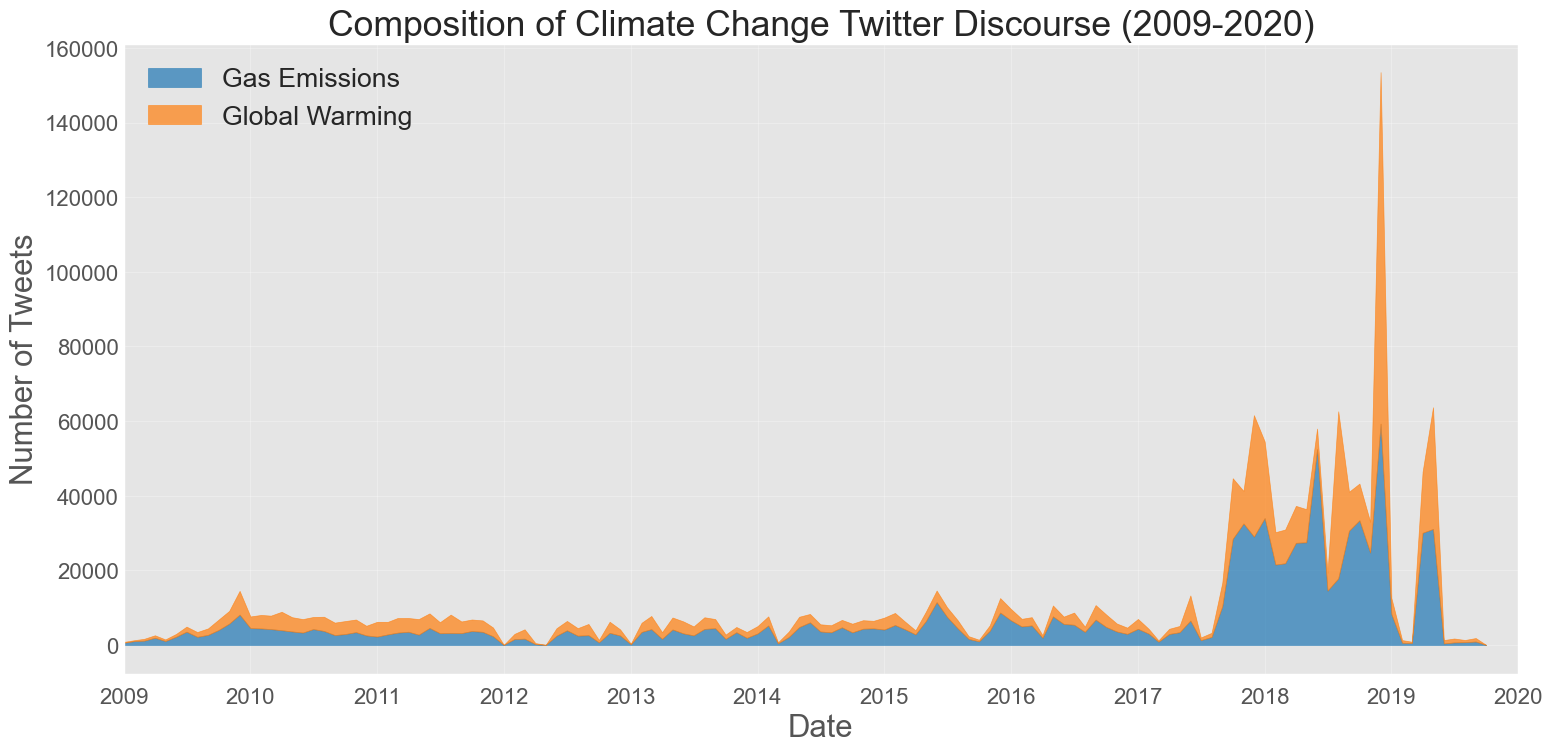

Summary statistics of the combined tweet data:
        total_volume  combined_aggressiveness  combined_sentiment
count     130.000000               130.000000          130.000000
mean    11561.807692                 0.308473           -0.087128
std     18606.247468                 0.077019            0.078093
min         9.000000                 0.111111           -0.341512
25%      4183.250000                 0.258491           -0.127361
50%      6443.500000                 0.310283           -0.086590
75%      8413.750000                 0.354938           -0.037500
max    153541.000000                 0.710737            0.252510

Top 5 months with highest climate change discussion volume:
          date  total_volume  combined_aggressiveness  combined_sentiment
143 2018-12-01      153541.0                 0.216086           -0.243849
148 2019-05-01       63721.0                 0.315955           -0.188711
139 2018-08-01       62635.0                 0.710737           -0.341512
13

In [7]:
# Improved Climate Change Analysis with Better Legislative Activity Visualization

# Import the improved visualization module
from improved_climate_visualization import create_improved_climate_visualization

# Run the improved visualization function with the topic_analysis dictionary
combined_data = create_improved_climate_visualization(topic_analysis)

# The function will generate two visualizations:
# 1. A split-view visualization with tweet metrics on top and legislative activity in a separate subplot below
# 2. A stacked area chart showing the composition of climate change discussions

# You can further analyze the combined data
combined_tweets = combined_data['combined_tweets']
combined_bills = combined_data['combined_bills']

print("Summary statistics of the combined tweet data:")
print(combined_tweets[['total_volume', 'combined_aggressiveness', 'combined_sentiment']].describe())

# Find periods with highest tweet volume
print("\nTop 5 months with highest climate change discussion volume:")
top_volume_months = combined_tweets.nlargest(5, 'total_volume')
print(top_volume_months[['date', 'total_volume', 'combined_aggressiveness', 'combined_sentiment']])

# Find periods with most legislative activity
if 'combined_bills' in combined_data and not combined_data['combined_bills'].empty:
    print("\nTop 5 months with highest legislative activity:")
    top_legislative_months = combined_data['combined_bills'].nlargest(5, 'total_bills')
    print(top_legislative_months[['date', 'total_bills']])


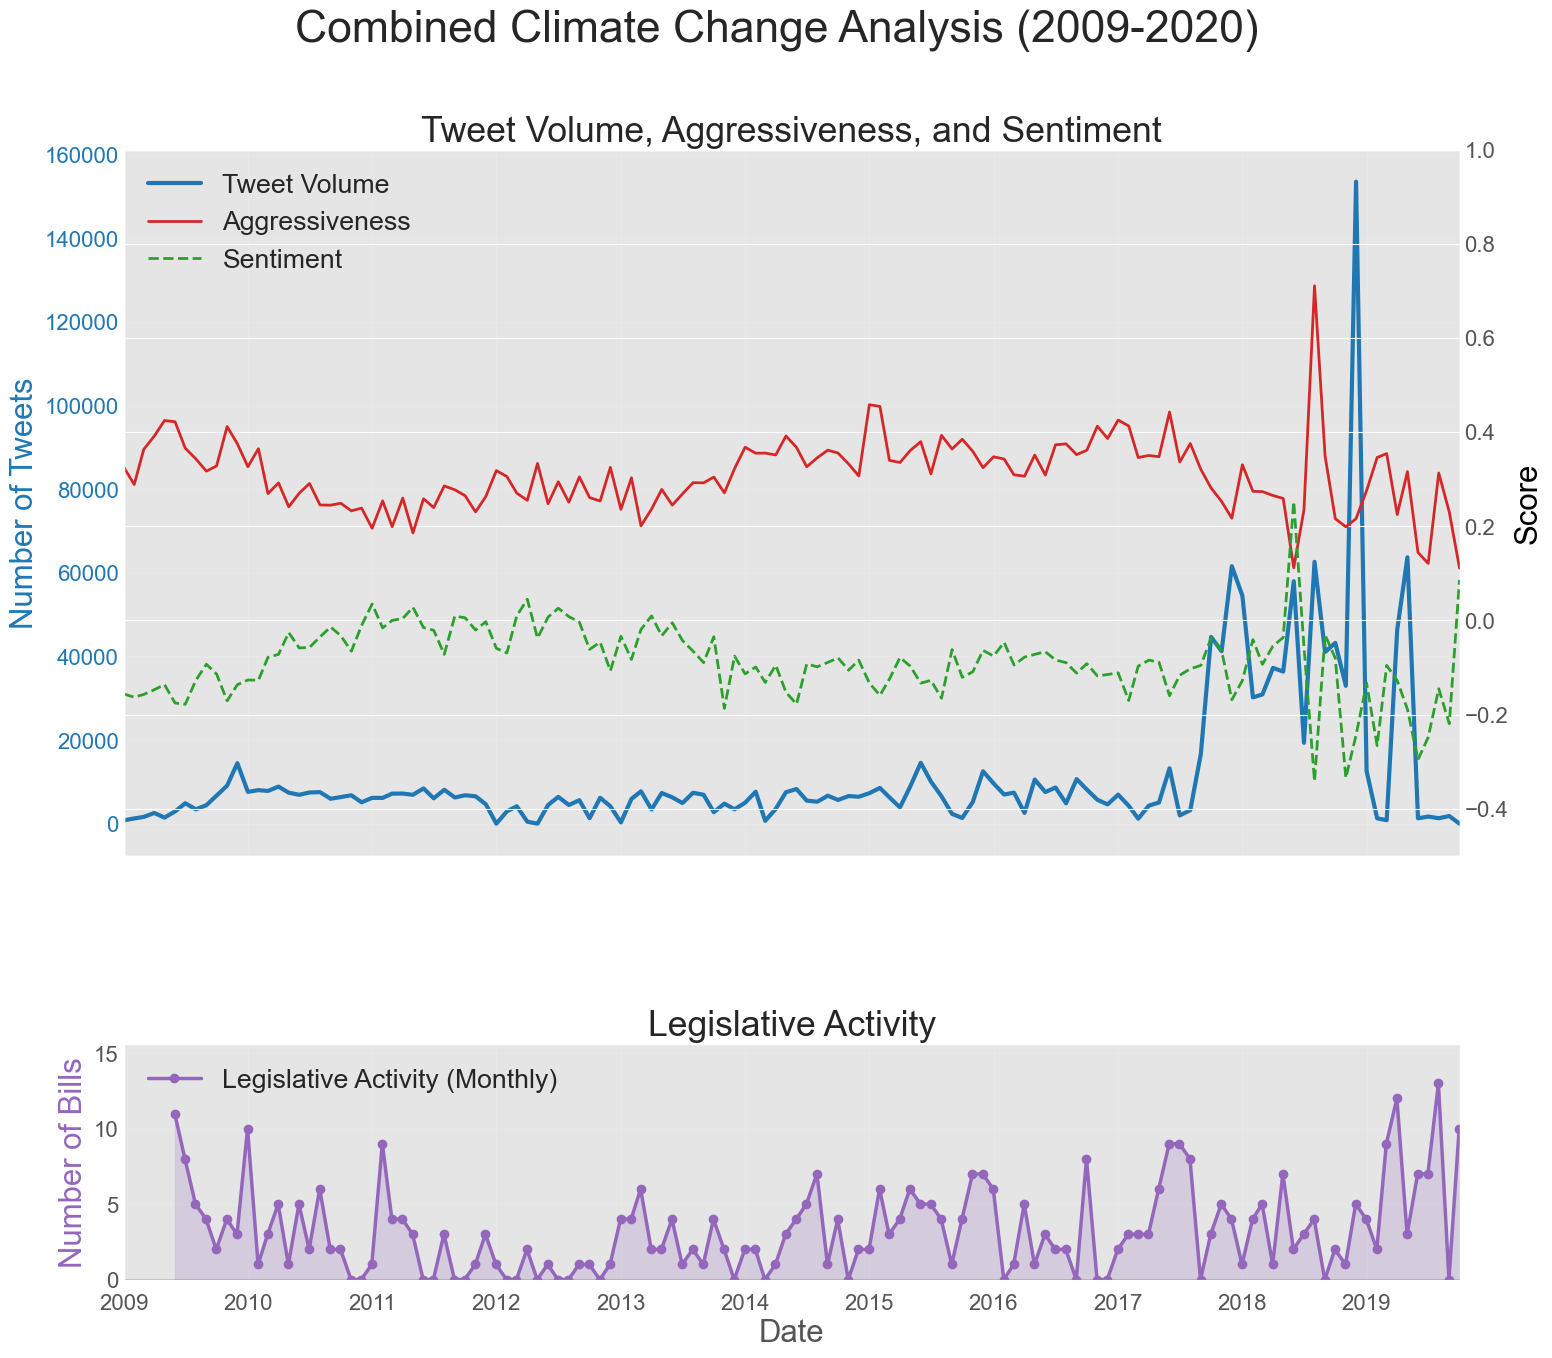

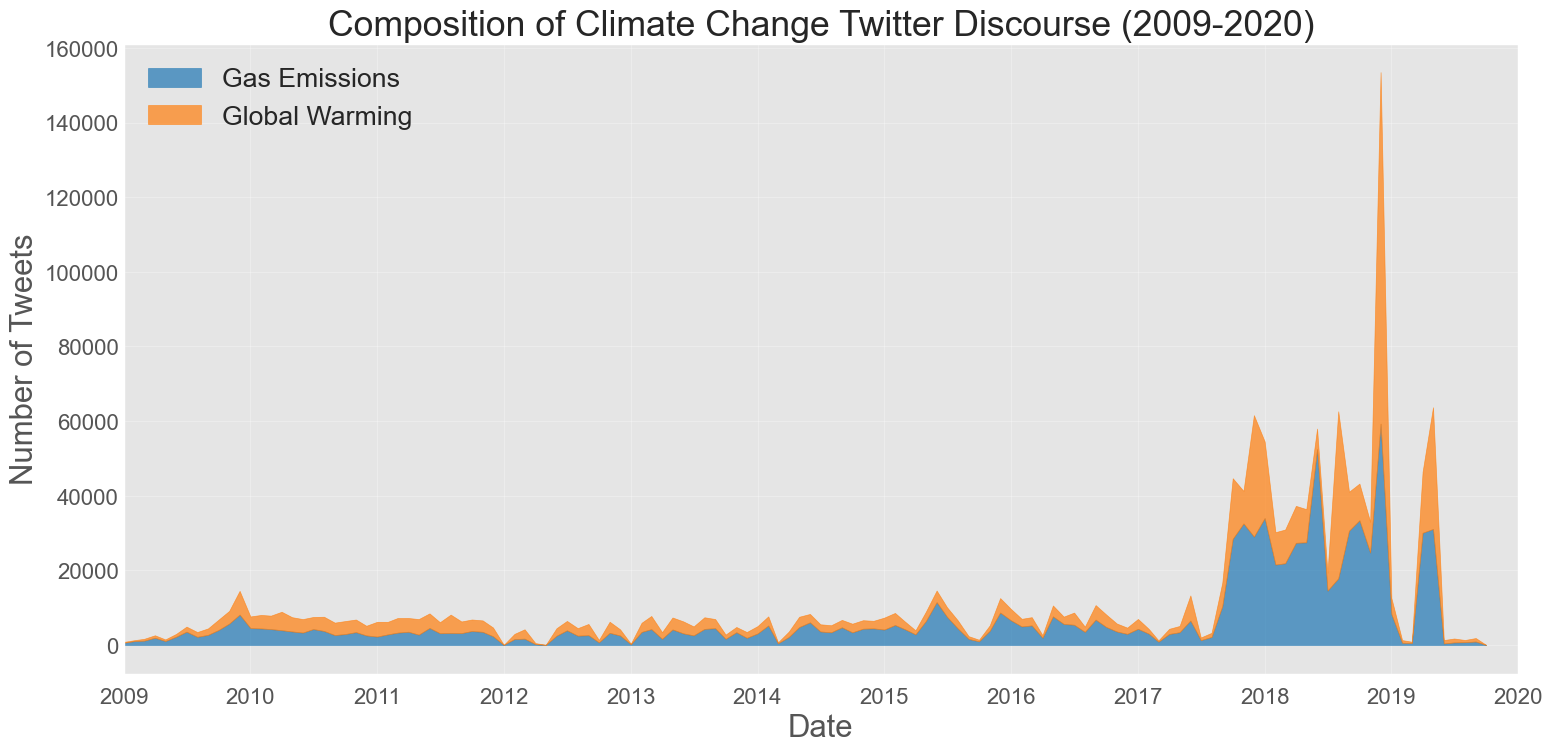

Summary statistics of the combined tweet data:
        total_volume  combined_aggressiveness  combined_sentiment
count     130.000000               130.000000          130.000000
mean    11561.807692                 0.308473           -0.087128
std     18606.247468                 0.077019            0.078093
min         9.000000                 0.111111           -0.341512
25%      4183.250000                 0.258491           -0.127361
50%      6443.500000                 0.310283           -0.086590
75%      8413.750000                 0.354938           -0.037500
max    153541.000000                 0.710737            0.252510

Top 5 months with highest climate change discussion volume:
          date  total_volume  combined_aggressiveness  combined_sentiment
143 2018-12-01      153541.0                 0.216086           -0.243849
148 2019-05-01       63721.0                 0.315955           -0.188711
139 2018-08-01       62635.0                 0.710737           -0.341512
13

In [8]:
# Improved Climate Change Analysis with Better Legislative Activity Visualization

# Import the improved visualization module
from improved_climate_visualization import create_improved_climate_visualization

# Run the improved climate change visualization with larger fonts and clearer x-axis labels
combined_data = create_improved_climate_visualization(topic_analysis)

# The function will generate two visualizations:
# 1. A split-view visualization with tweet metrics on top and legislative activity in a separate subplot below
#    - Now with 60% larger fonts
#    - Clearer year labels on the x-axis
#    - Larger annotations and labels
# 2. A stacked area chart showing the composition of climate change discussions

# You can further analyze the combined data
combined_tweets = combined_data['combined_tweets']
combined_bills = combined_data['combined_bills']

print("Summary statistics of the combined tweet data:")
print(combined_tweets[['total_volume', 'combined_aggressiveness', 'combined_sentiment']].describe())

# Find periods with highest tweet volume
print("\nTop 5 months with highest climate change discussion volume:")
top_volume_months = combined_tweets.nlargest(5, 'total_volume')
print(top_volume_months[['date', 'total_volume', 'combined_aggressiveness', 'combined_sentiment']])

# Find periods with most legislative activity
if 'combined_bills' in combined_data and not combined_data['combined_bills'].empty:
    print("\nTop 5 months with highest legislative activity:")
    top_legislative_months = combined_data['combined_bills'].nlargest(5, 'total_bills')
    print(top_legislative_months[['date', 'total_bills']])


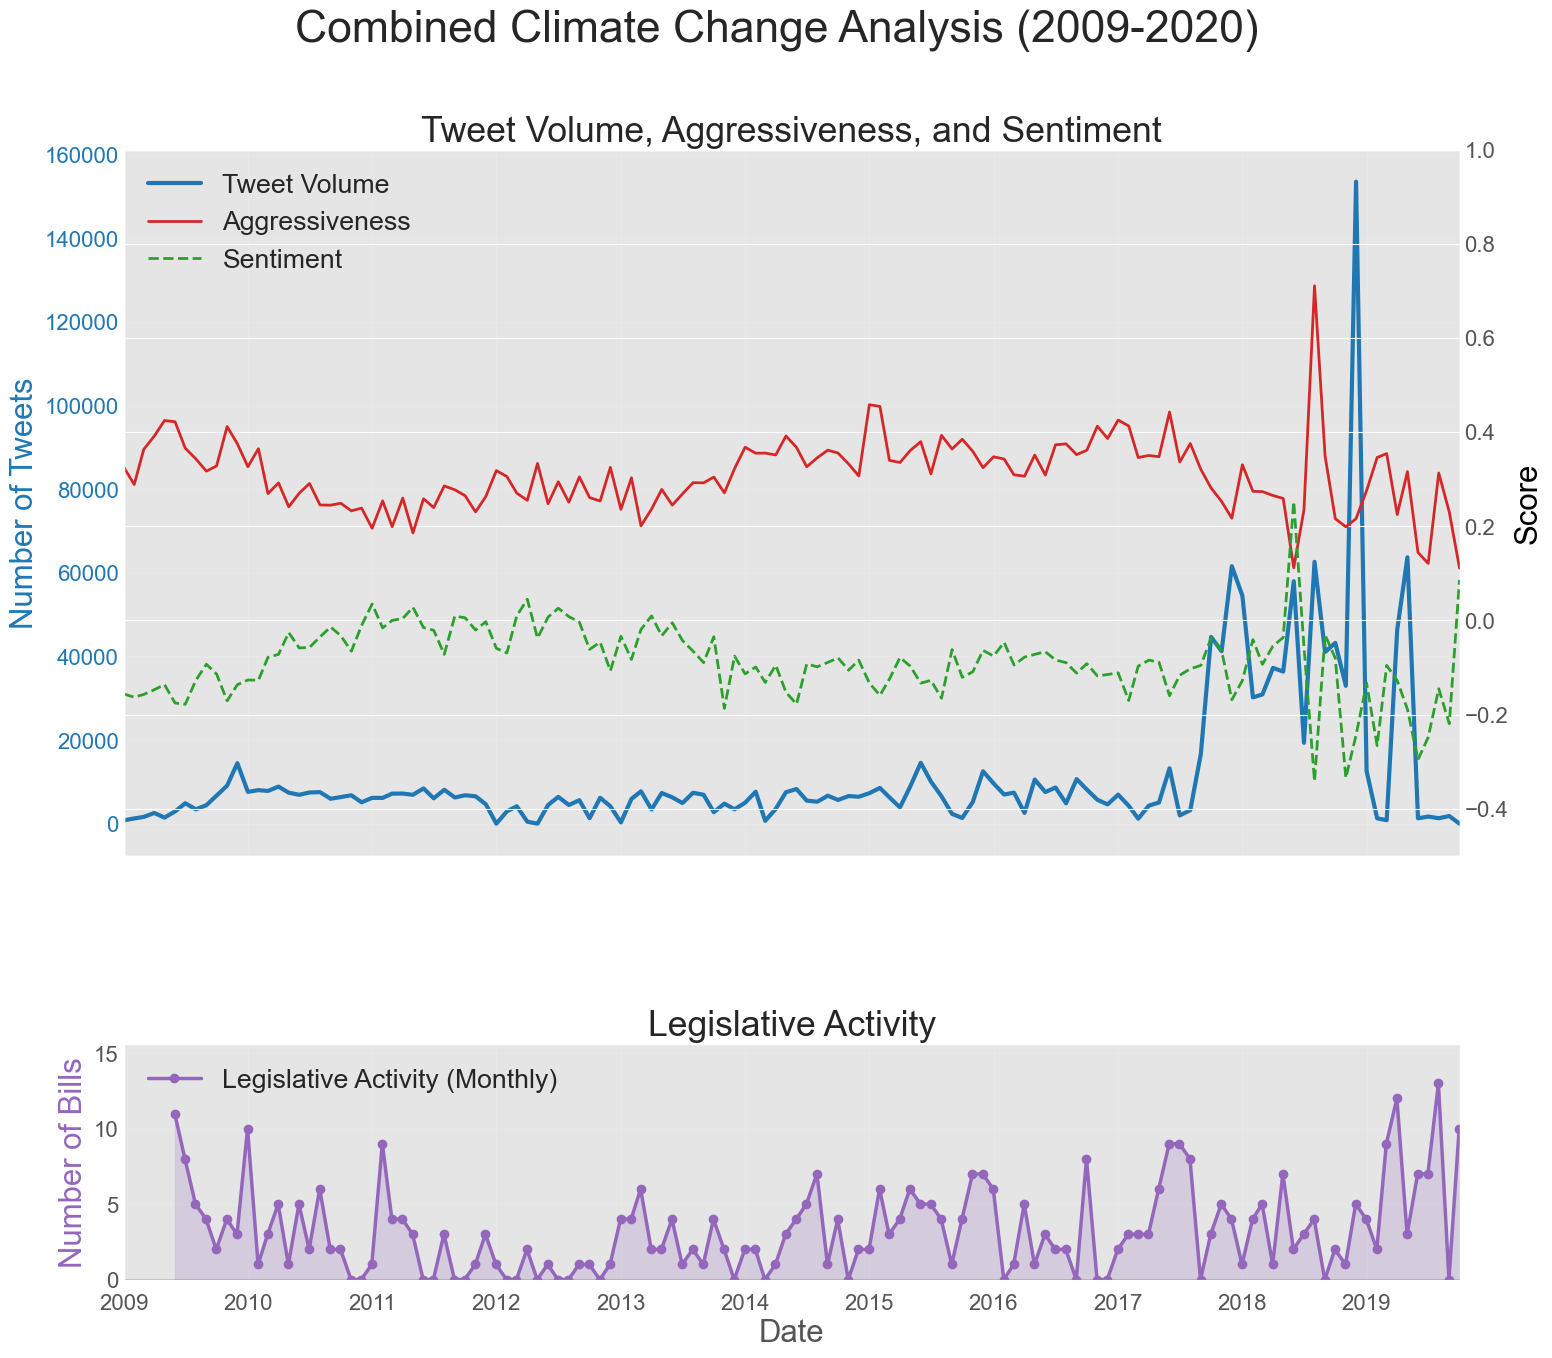

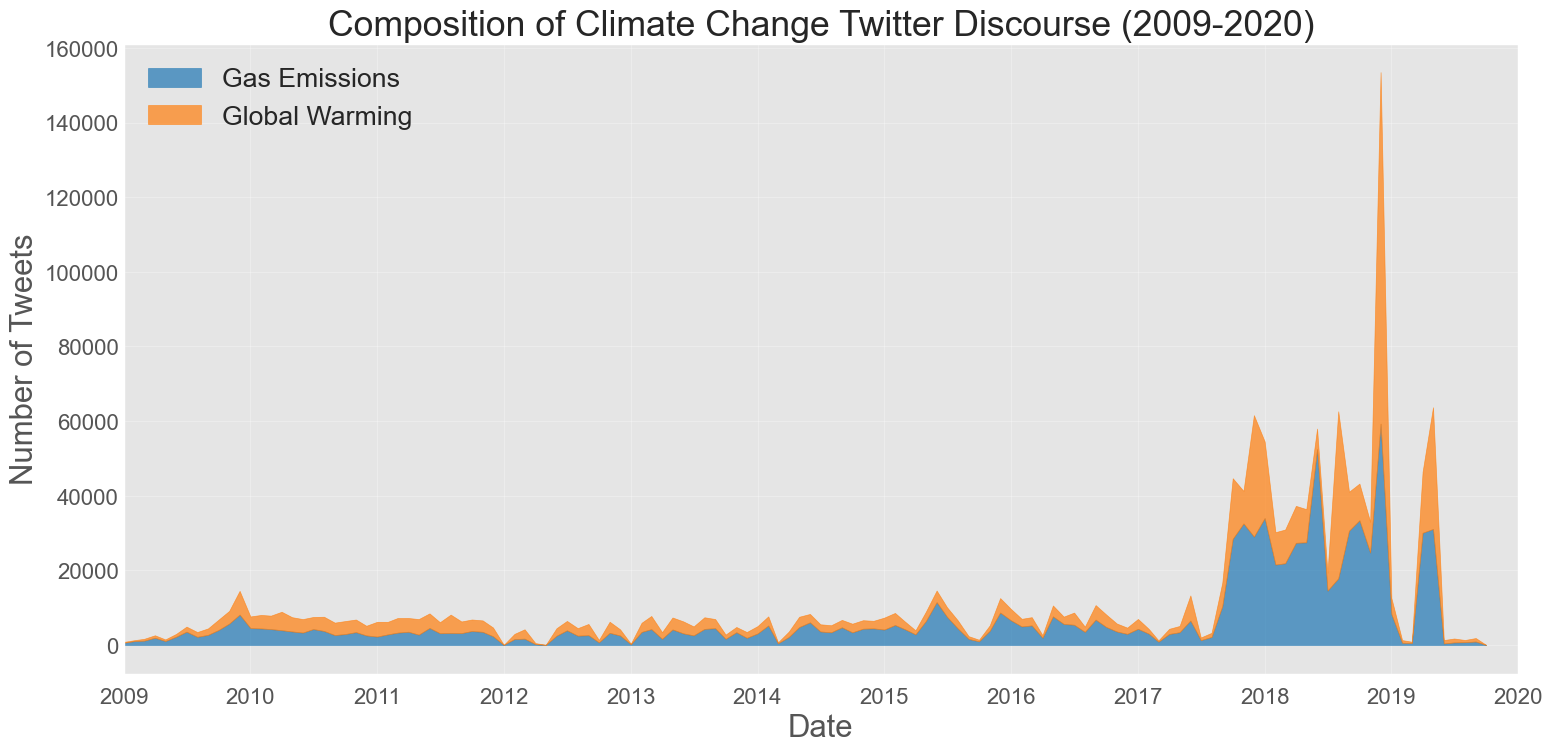

In [9]:
# Import the improved visualization module with larger fonts and clearer x-axis labels
from improved_climate_visualization import create_improved_climate_visualization

# Run the improved visualization function with your existing topic_analysis data
combined_data = create_improved_climate_visualization(topic_analysis)

# The visualizations will be displayed with:
# - 60% larger fonts
# - Years clearly visible on the x-axis
# - Larger labels and annotations


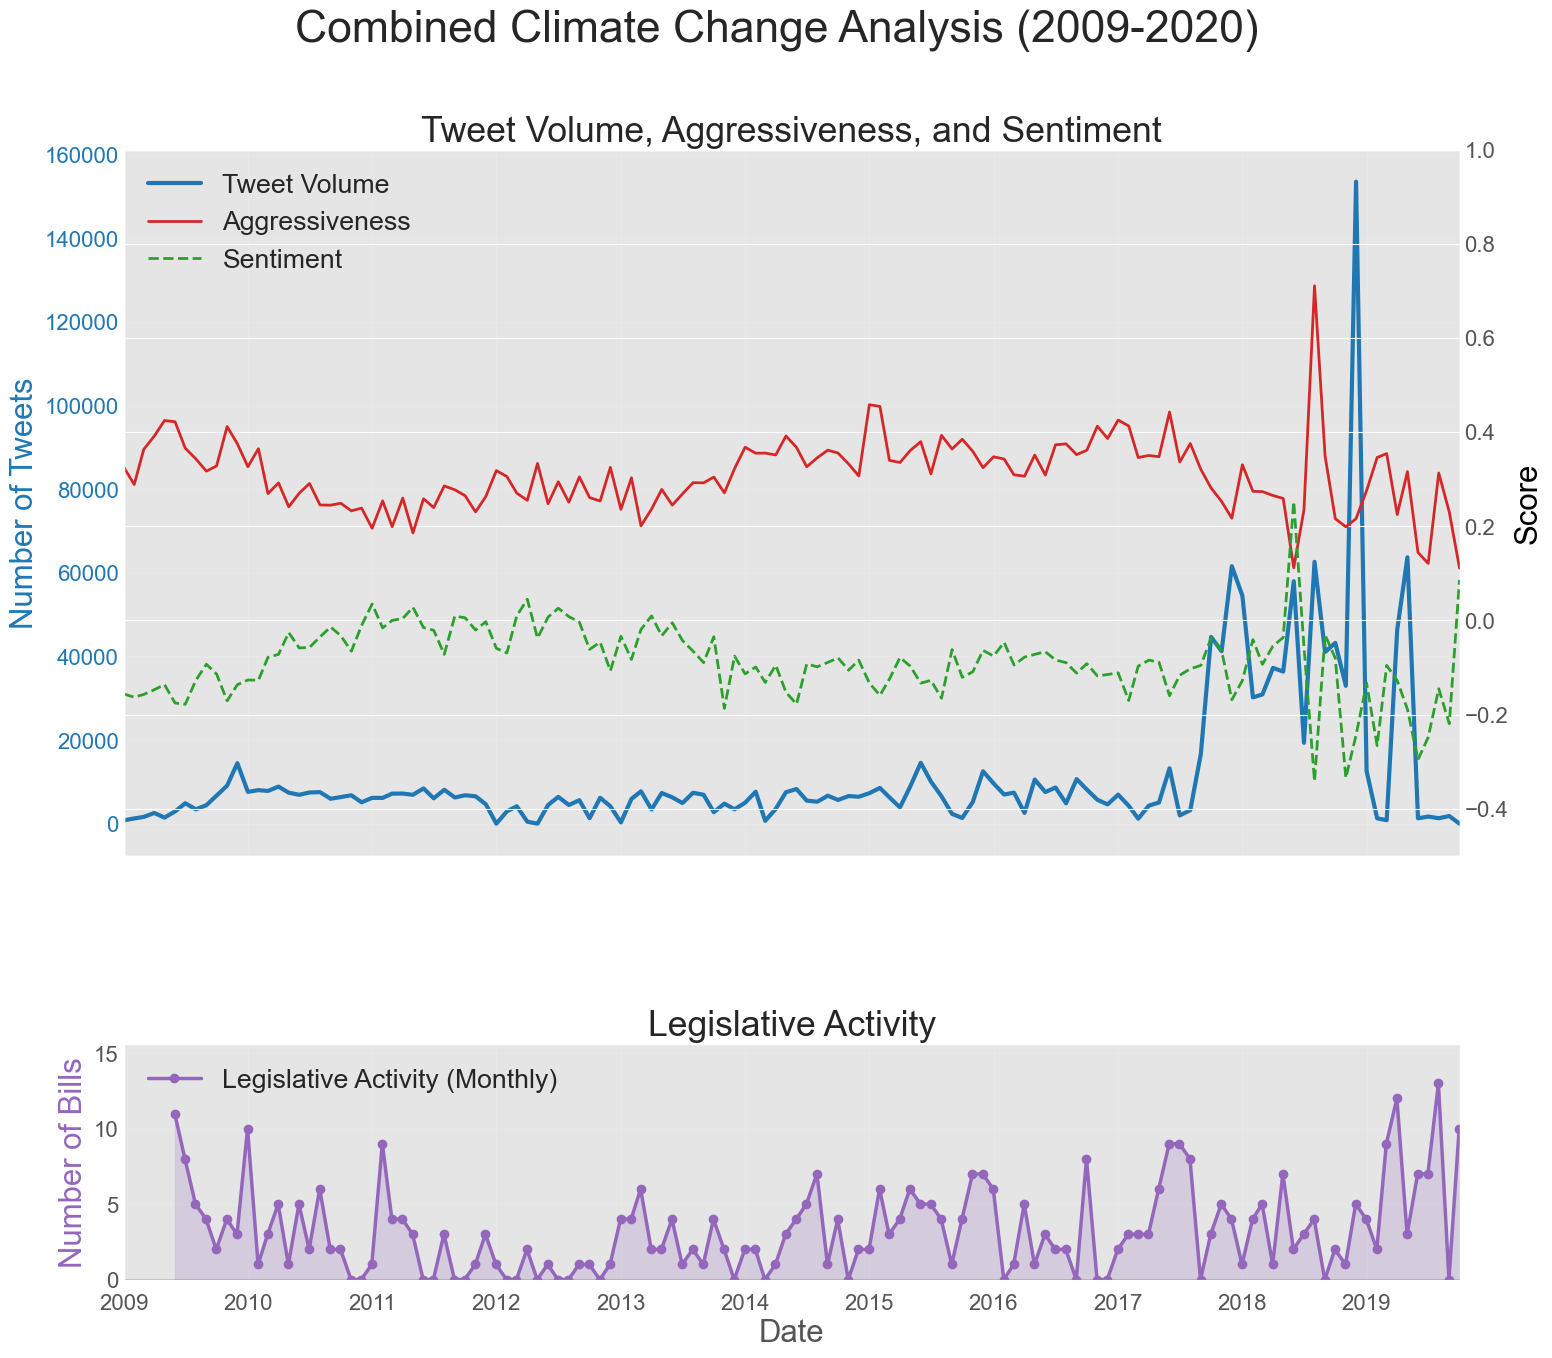

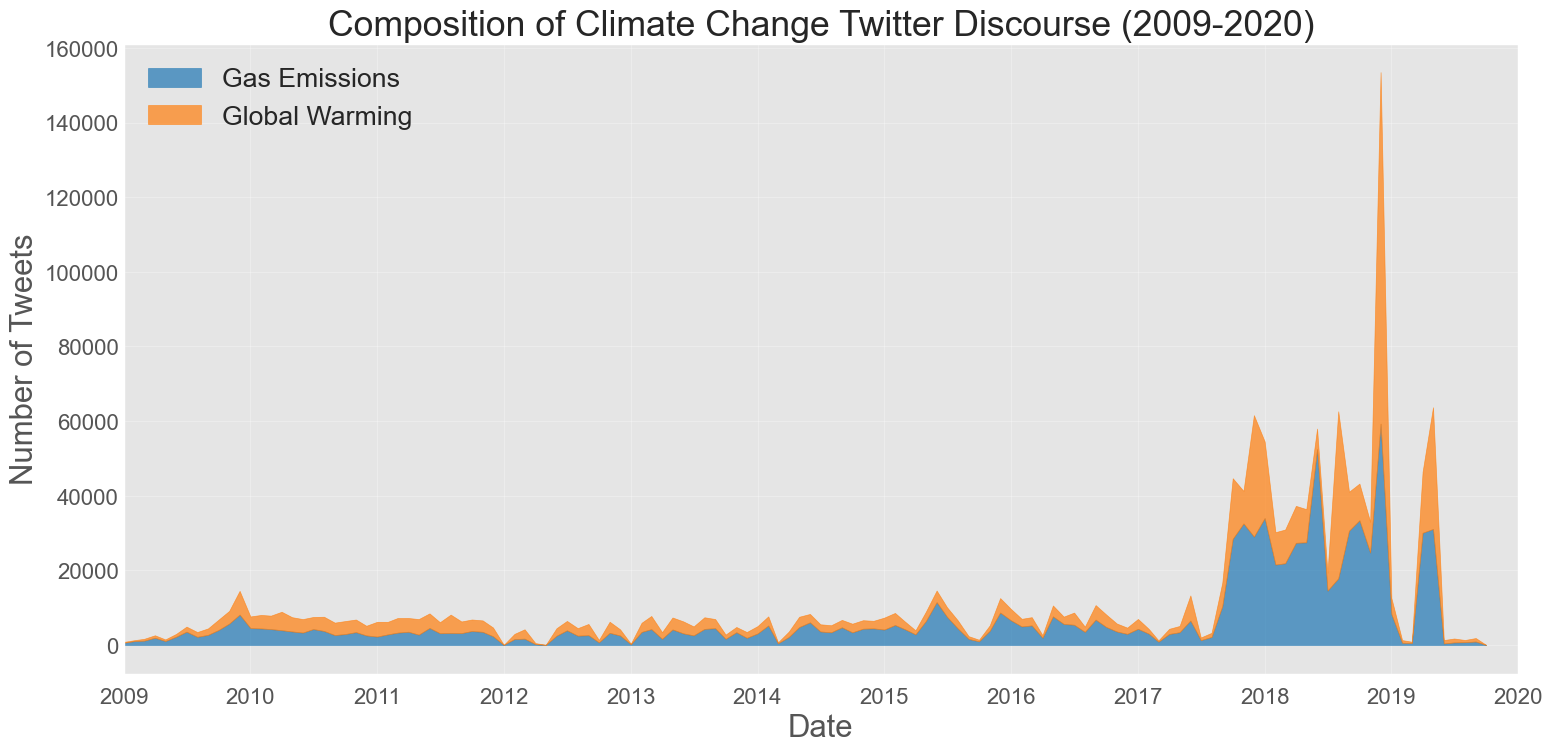

In [10]:
# Import the improved visualization module with larger fonts and clearer x-axis labels
from improved_climate_visualization import create_improved_climate_visualization

# Run the improved visualization function with your existing topic_analysis data
combined_data = create_improved_climate_visualization(topic_analysis)

# The visualizations will be displayed with:
# - 60% larger fonts
# - Years clearly visible on the x-axis
# - Larger labels and annotations


## 5. Regression Analysis



Analyzing the impact of tweet metrics on future legislative activity with extended time lags...
Total days in dataset: 36
Days with non-zero next-day legislative activity: 18
Days with non-zero next-week legislative activity: 12
Days with non-zero next-30-days legislative activity: 8
Days with non-zero next-60-days legislative activity: 18
Days with non-zero next-90-days legislative activity: 26

--- STANDARD TIME LAGS ---

Regression: Today's Metrics vs. Next Day Legislative Activity

Aggressiveness vs. Legislative Activity:
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -3.8927      2.059     -1.891      0.067      -8.077       0.291
combined_aggressiveness    21.5326      7.030      3.063      0.004       7.245      35.820


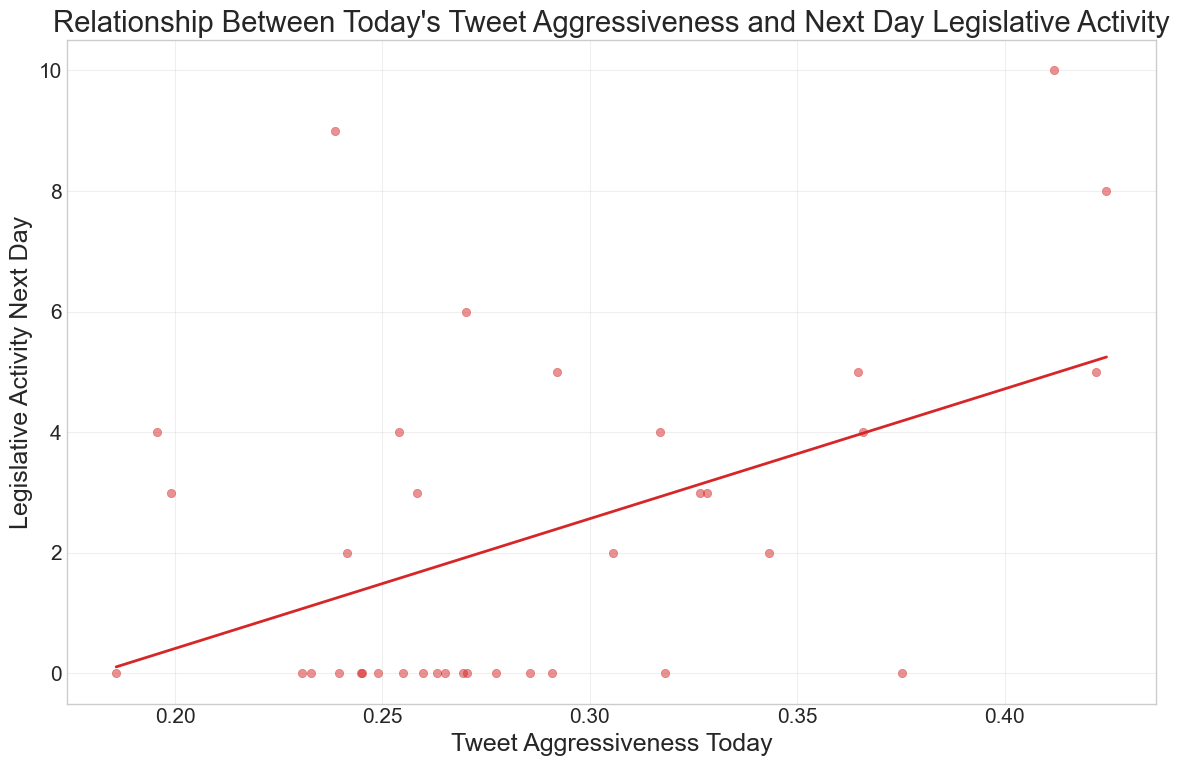


Sentiment vs. Legislative Activity:
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  1.1257      0.571      1.972      0.057      -0.034       2.286
combined_sentiment   -21.0079      6.939     -3.027      0.005     -35.110      -6.906


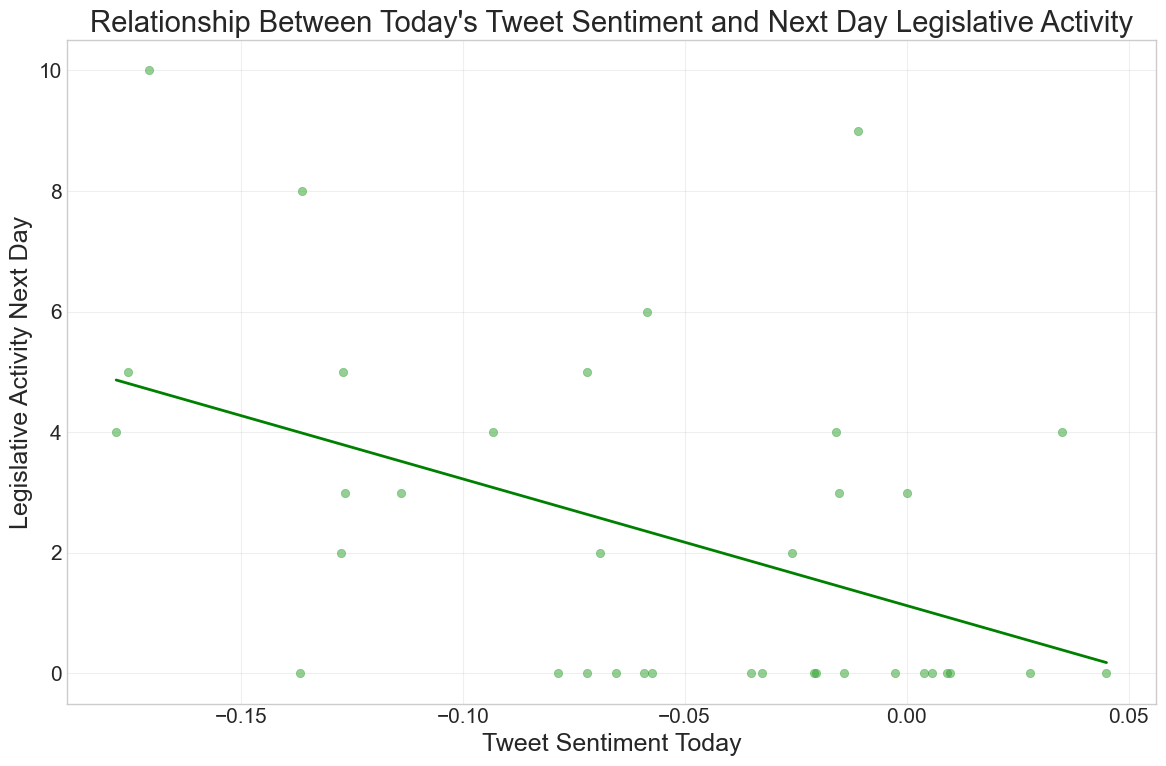


Combined Metrics vs. Legislative Activity:
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -1.7934      3.651     -0.491      0.627      -9.221       5.634
combined_aggressiveness    12.2199     15.093      0.810      0.424     -18.488      42.927
combined_sentiment        -10.3838     14.861     -0.699      0.490     -40.618      19.850

Regression: Today's Metrics vs. Next Week Legislative Activity

Aggressiveness vs. Legislative Activity:
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -3.5231      1.989     -1.771      0.085      -7.565       0.519
combined_aggressiveness    17.7226      6.791      2.610      0.013       3.921      31.524


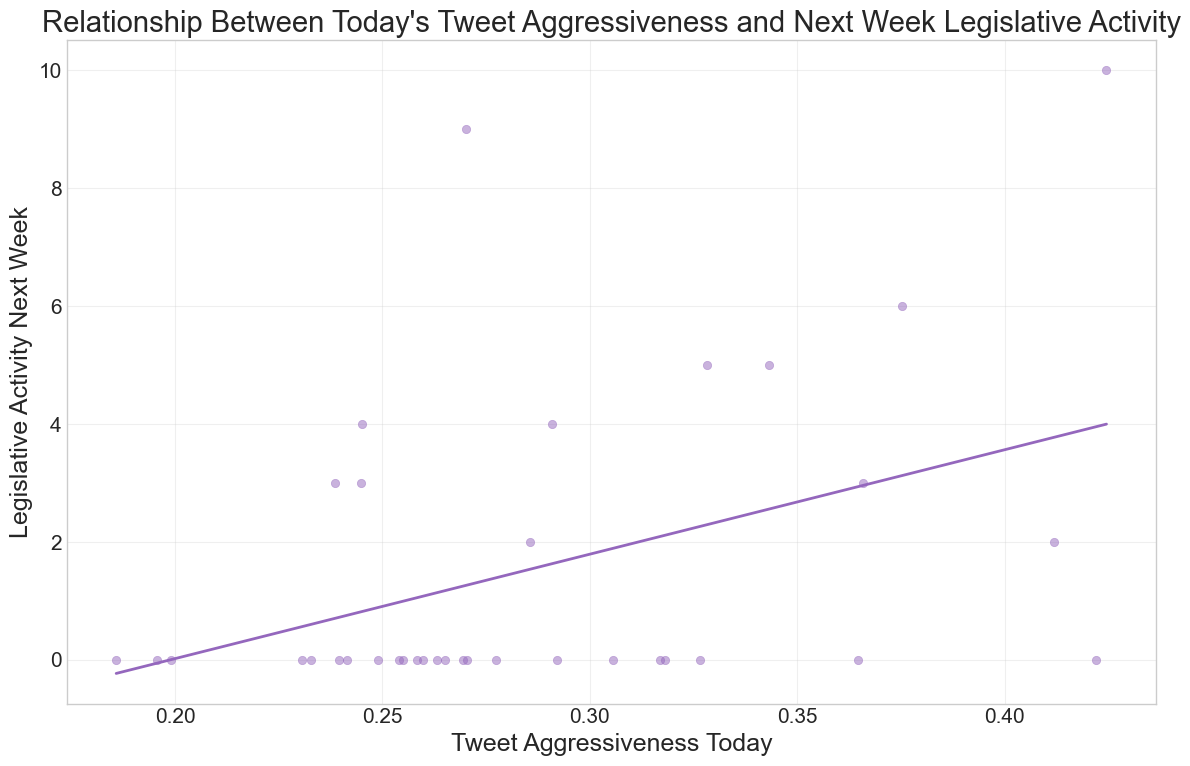


Sentiment vs. Legislative Activity:
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.6199      0.552      1.122      0.270      -0.503       1.743
combined_sentiment   -17.0623      6.716     -2.541      0.016     -30.711      -3.414


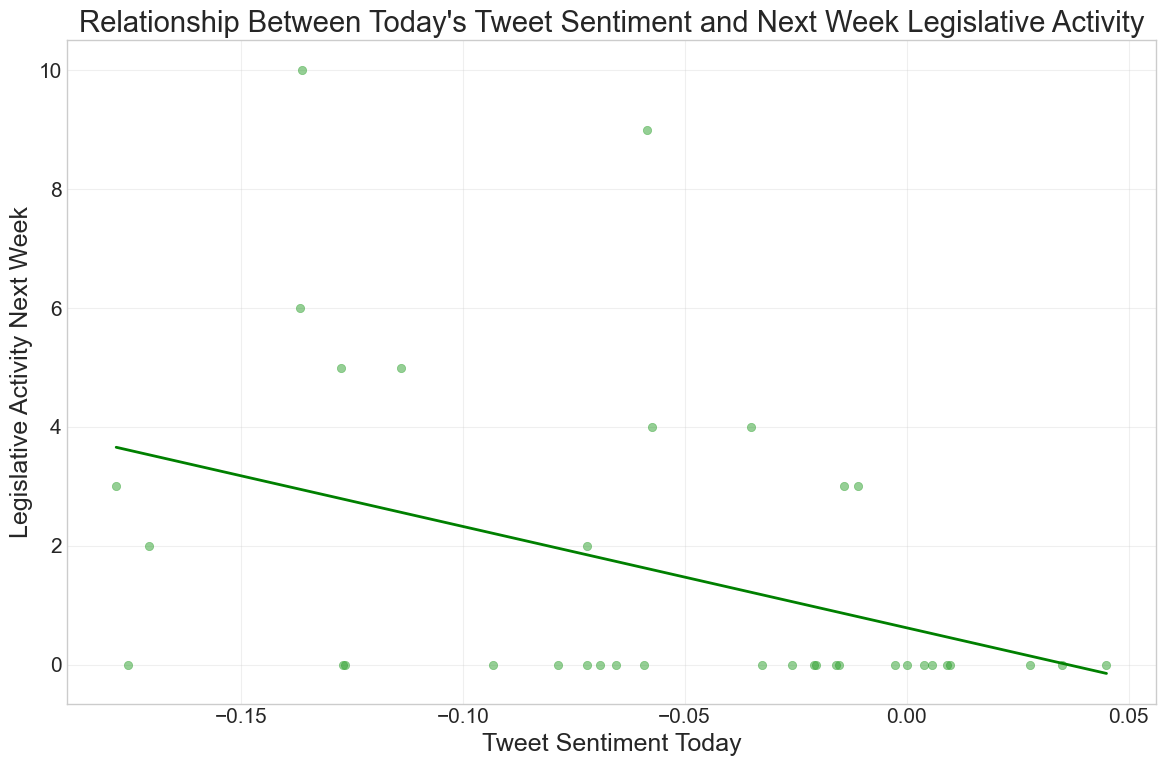


Combined Metrics vs. Legislative Activity:
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -2.0050      3.538     -0.567      0.575      -9.204       5.194
combined_aggressiveness    10.9880     14.628      0.751      0.458     -18.773      40.749
combined_sentiment         -7.5092     14.403     -0.521      0.606     -36.811      21.793

--- EXTENDED TIME LAGS ---

Regression: Today's Metrics vs. Next 30 Days Legislative Activity

Aggressiveness vs. Legislative Activity:
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       1.8756      1.519      1.235      0.225      -1.212       4.963
combined_aggressiveness    -3.4432      5.187     -0.664      0.511     -13.985    

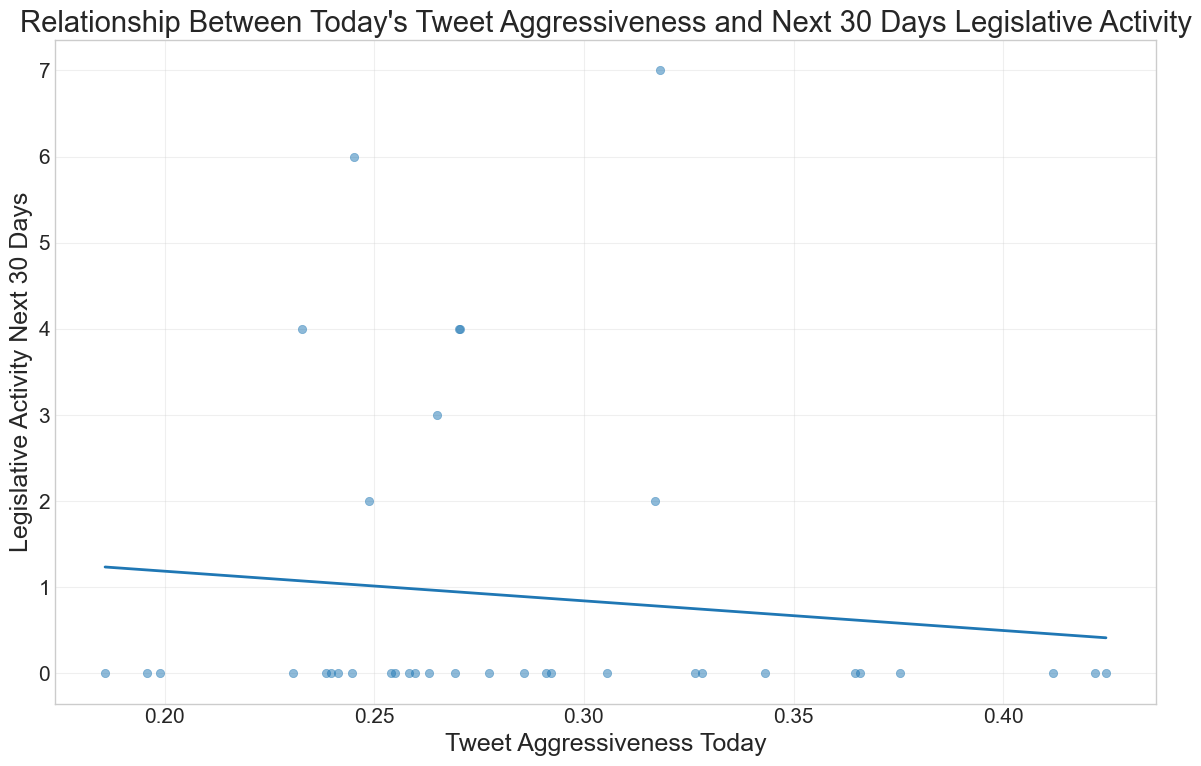


Sentiment vs. Legislative Activity:
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  1.0668      0.420      2.538      0.016       0.213       1.921
combined_sentiment     3.2447      5.110      0.635      0.530      -7.140      13.630


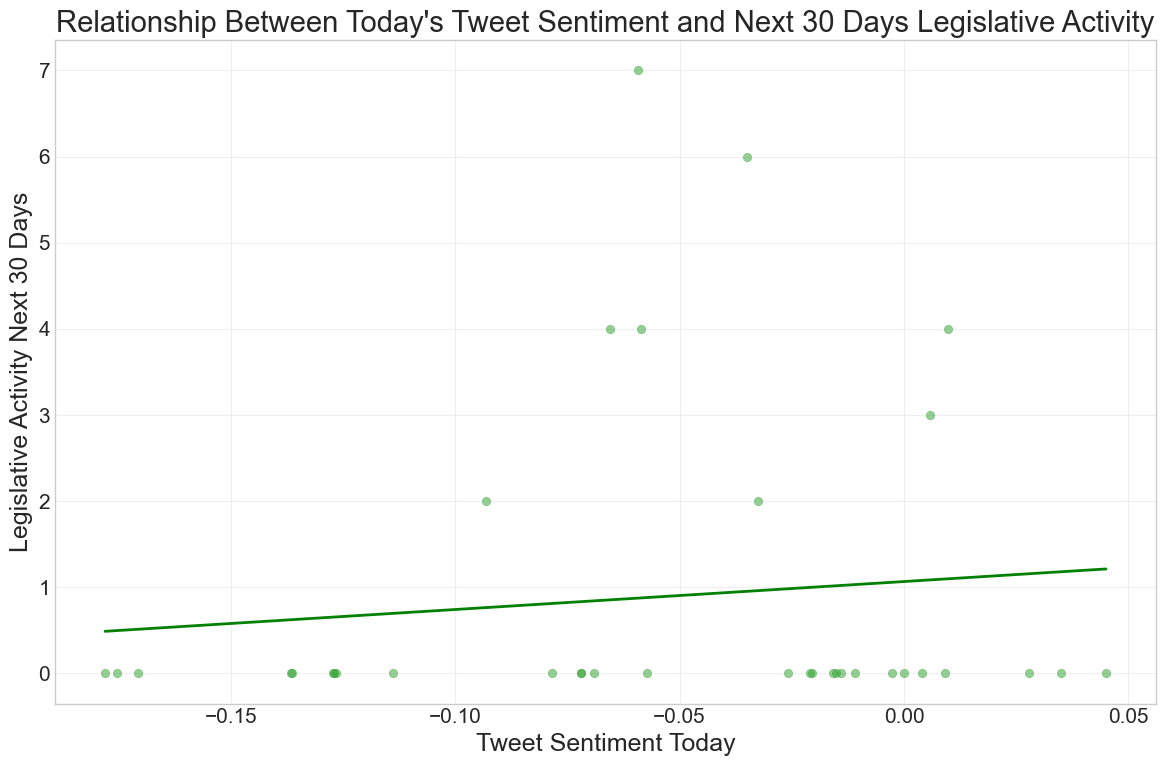


Combined Metrics vs. Legislative Activity:
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       1.6451      2.713      0.606      0.548      -3.875       7.165
combined_aggressiveness    -2.4207     11.217     -0.216      0.830     -25.242      20.401
combined_sentiment          1.1401     11.044      0.103      0.918     -21.330      23.610

Regression: Today's Metrics vs. Next 60 Days Legislative Activity

Aggressiveness vs. Legislative Activity:
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       5.1872      2.241      2.314      0.027       0.632       9.742
combined_aggressiveness    -9.4741      7.653     -1.238      0.224     -25.027       6.079


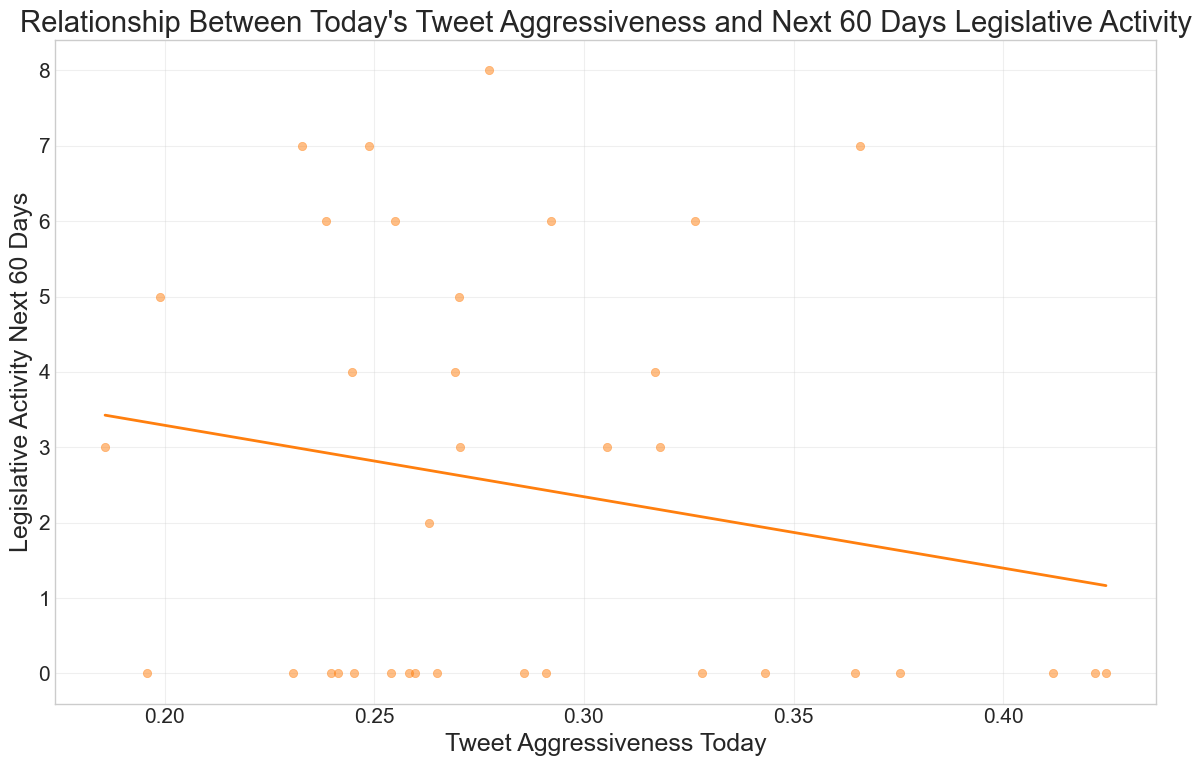


Sentiment vs. Legislative Activity:
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  2.7650      0.629      4.395      0.000       1.486       4.043
combined_sentiment     5.3384      7.649      0.698      0.490     -10.205      20.882


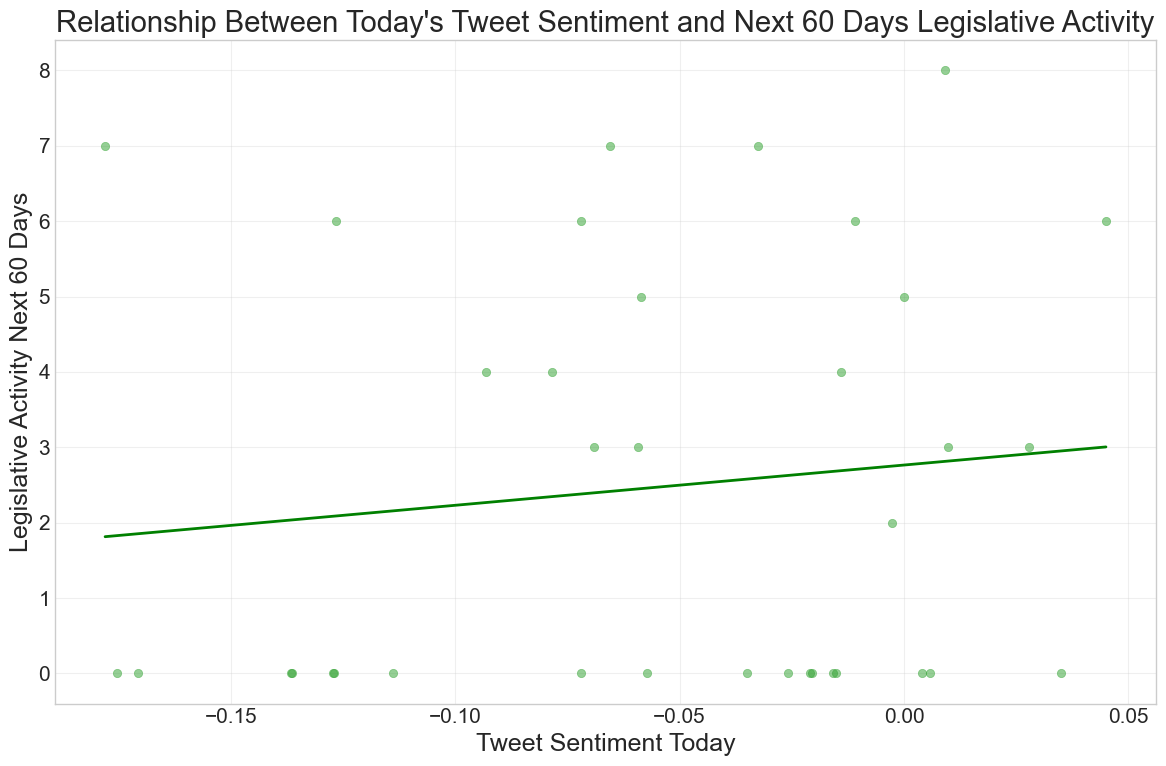


Combined Metrics vs. Legislative Activity:
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       7.8474      3.964      1.980      0.056      -0.217      15.912
combined_aggressiveness   -21.2755     16.387     -1.298      0.203     -54.616      12.065
combined_sentiment        -13.1588     16.135     -0.816      0.421     -45.985      19.668

Regression: Today's Metrics vs. Next 90 Days Legislative Activity

Aggressiveness vs. Legislative Activity:
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       2.5894      3.062      0.846      0.404      -3.633       8.812
combined_aggressiveness     5.6011     10.456      0.536      0.596     -15.647      26.850


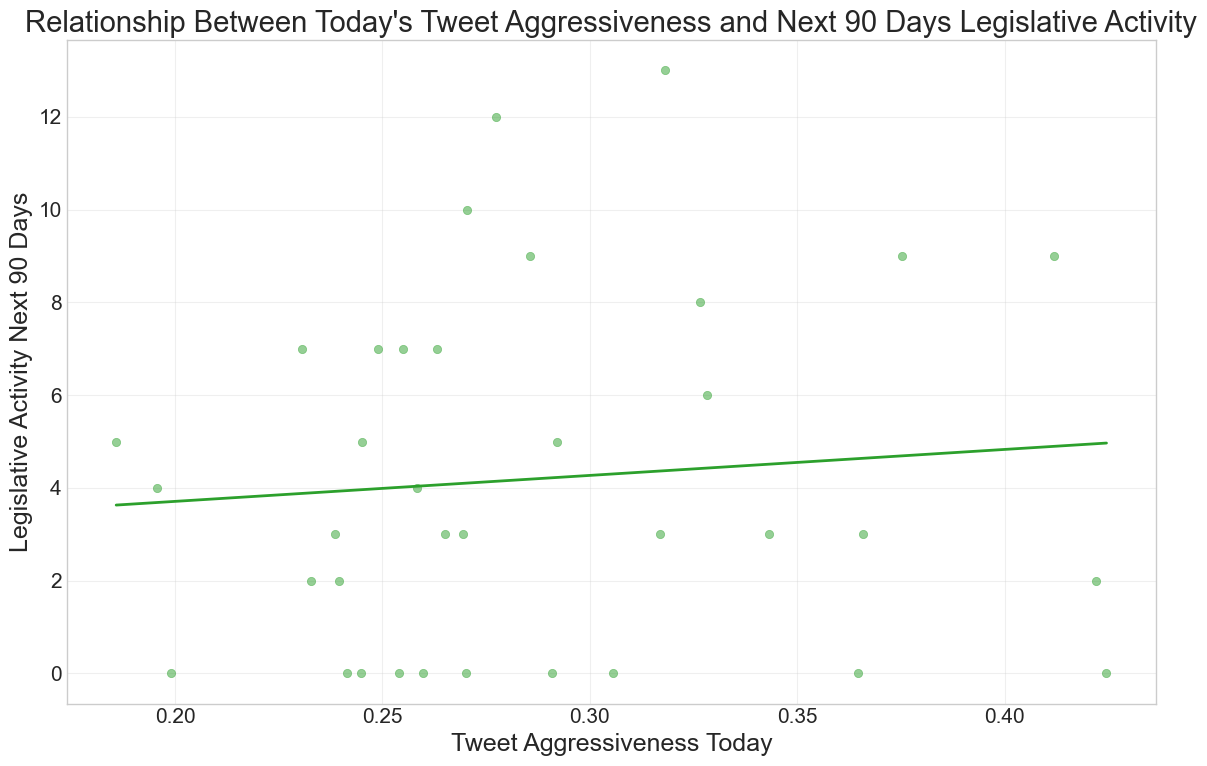


Sentiment vs. Legislative Activity:
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  4.2939      0.850      5.052      0.000       2.567       6.021
combined_sentiment     1.8137     10.333      0.176      0.862     -19.186      22.813


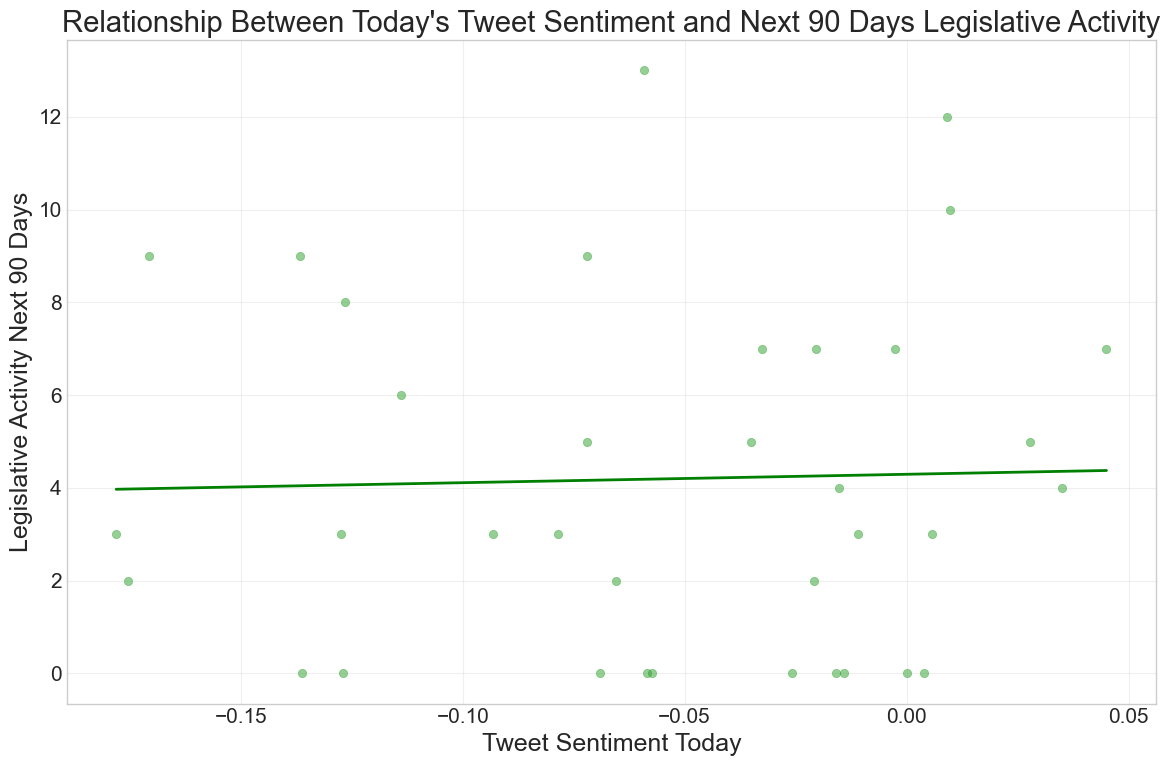


Combined Metrics vs. Legislative Activity:
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -3.5446      5.314     -0.667      0.509     -14.355       7.266
combined_aggressiveness    32.8128     21.967      1.494      0.145     -11.880      77.506
combined_sentiment         30.3415     21.629      1.403      0.170     -13.663      74.346


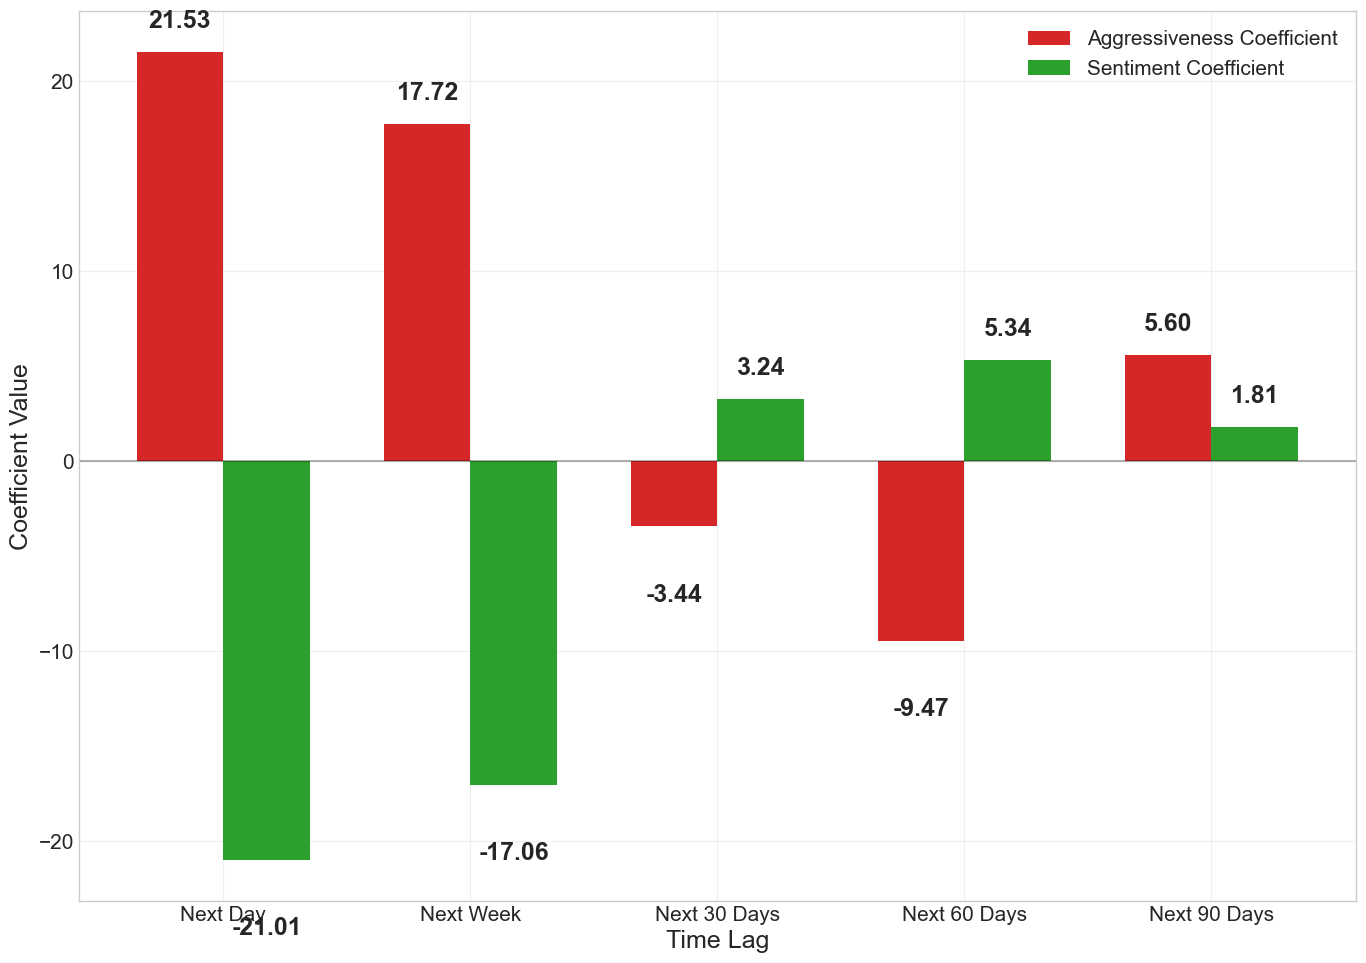

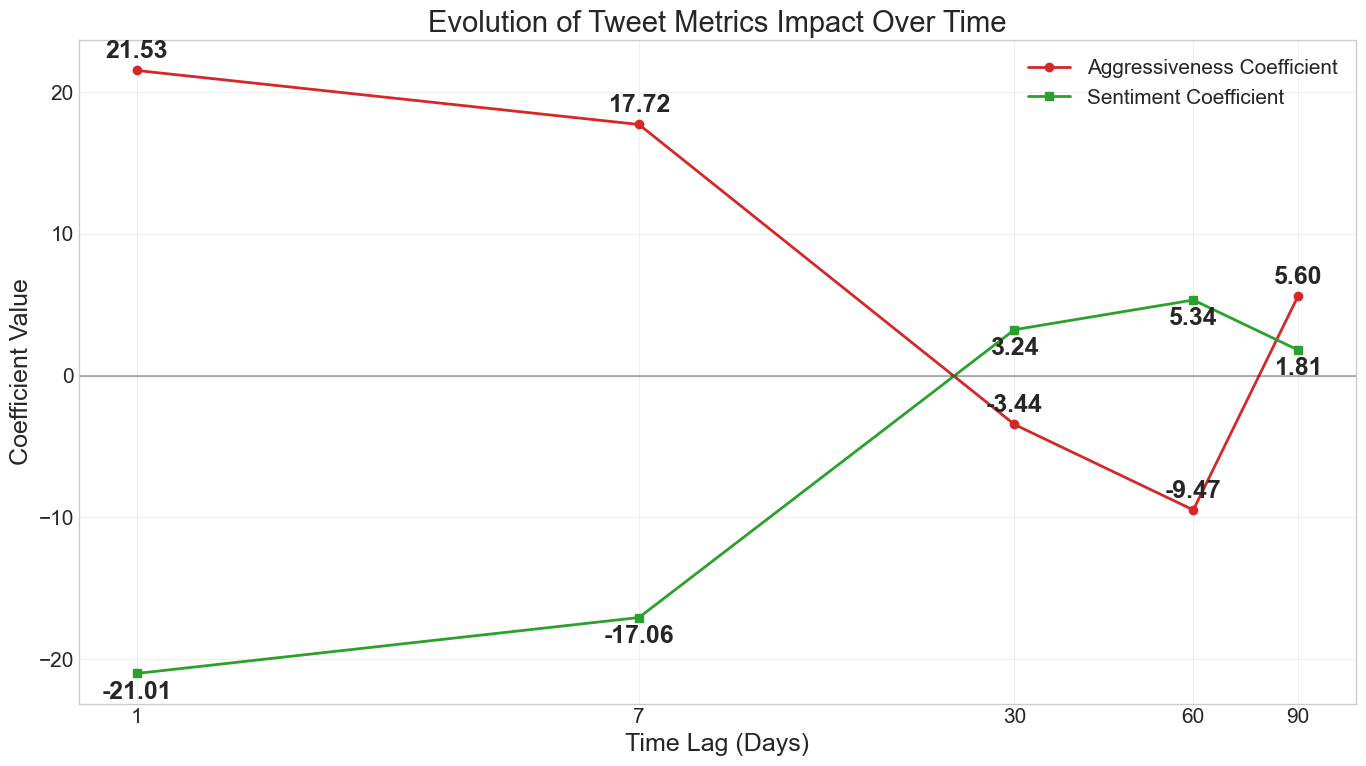


--- SUMMARY OF FINDINGS ---
Coefficient values across different time lags:

Aggressiveness coefficients:
Next Day: 21.5326 (p-value: 0.0043)
Next Week: 17.7226 (p-value: 0.0134)
Next 30 Days: -3.4432 (p-value: 0.5113)
Next 60 Days: -9.4741 (p-value: 0.2242)
Next 90 Days: 5.6011 (p-value: 0.5957)

Sentiment coefficients:
Next Day: -21.0079 (p-value: 0.0047)
Next Week: -17.0623 (p-value: 0.0158)
Next 30 Days: 3.2447 (p-value: 0.5297)
Next 60 Days: 5.3384 (p-value: 0.4899)
Next 90 Days: 1.8137 (p-value: 0.8617)


In [30]:
from tweet_metrics_legislative_impact_extended_lags import analyze_tweet_metrics_legislative_impact_extended

# Run the extended time lag analysis
extended_regression_results = analyze_tweet_metrics_legislative_impact_extended(topic_analysis)